In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import cv2
import random
from PIL import Image
import time
from tqdm import tqdm


random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

noisy_img_array = np.load('./data/noisy_img_array.npy', allow_pickle=True)
gt_img_array = np.load('./data/gt_img_array.npy', allow_pickle=True)

# Normalize images to [0, 1] range
noisy_img_array = noisy_img_array.astype(np.float32) / 255.0
gt_img_array = gt_img_array.astype(np.float32) / 255.0

print(noisy_img_array.shape)
print(gt_img_array.shape)

print(np.max(noisy_img_array), np.min(noisy_img_array))
print(np.max(gt_img_array), np.min(gt_img_array))

(160, 1024, 1024, 3)
(160, 1024, 1024, 3)
1.0 0.0
1.0 0.0


In [2]:
class SIDD_Dataset(Dataset):
    def __init__(self, noisy, gt, img_size=512, cache_dir='./dataset_cache'):
        """
        SIDD 데이터셋 클래스 (완전 캐싱 기능 포함)
        """
        print(f"=== SIDD_Dataset 초기화 (img_size={img_size}) ===")
        
        # 캐시 디렉토리 생성
        os.makedirs(cache_dir, exist_ok=True)
        
        # 빠른 데이터 해시값 계산 (캐시 키로 사용)
        data_id = f"sidd_processed_{img_size}"
        cache_file = os.path.join(cache_dir, f'{data_id}.pt')
        
        # 캐시 파일이 존재하는지 확인
        if os.path.exists(cache_file):
            print(f"캐시 파일을 로드합니다: {cache_file}")
            start_time = time.time()
            cache_data = torch.load(cache_file)
            self.img1_all = cache_data['img1']
            self.img2_all = cache_data['img2']
            self.img3_all = cache_data['img3']
            self.downsampled_gt = cache_data['downsampled_gt']
            print(f"캐시 로드 완료. 소요 시간: {time.time() - start_time:.2f}초")
            print(f"데이터 크기: {len(self.img1_all)} 샘플, 이미지 크기: {self.img1_all.shape[2]}x{self.img1_all.shape[3]}")
        else:
            print("데이터셋을 처리하고 캐싱합니다...")
            start_time = time.time()
            
            # 데이터 전처리 및 리사이징
            if np.max(noisy) > 1.0:
                noisy = noisy.astype(np.float32) / 255.0
                gt = gt.astype(np.float32) / 255.0
                
            # 텐서 변환 및 채널 순서 변경
            noisy_tensor = torch.tensor(noisy, dtype=torch.float32).permute(0, 3, 1, 2)
            gt_tensor = torch.tensor(gt, dtype=torch.float32).permute(0, 3, 1, 2)
            
            # Resize
            transform = transforms.Resize((img_size, img_size), 
                                        interpolation=transforms.InterpolationMode.BILINEAR,
                                        antialias=True)
            noisy_resized = transform(noisy_tensor)
            gt_resized = transform(gt_tensor)
            
            # 짝수 크기로 조정
            c, h, w = noisy_resized.shape[1], noisy_resized.shape[2], noisy_resized.shape[3]
            if h % 2 != 0:
                noisy_resized = noisy_resized[:, :, :h-1, :]
                gt_resized = gt_resized[:, :, :h-1, :]
            if w % 2 != 0:
                noisy_resized = noisy_resized[:, :, :, :w-1]
                gt_resized = gt_resized[:, :, :, :w-1]
            
            # 다운샘플링된 GT
            self.downsampled_gt = F.avg_pool2d(gt_resized, kernel_size=2, stride=2)
            
            # 출력 크기 계산
            n_samples = len(noisy_resized)
            c = noisy_resized.shape[1]
            out_h, out_w = h // 2, w // 2
            
            # 모든 샘플을 미리 처리 (실제 최적화 부분!)
            print(f"모든 샘플에 대해 2x2 샘플링을 미리 처리합니다...")
            self.img1_all = torch.zeros((n_samples, c, out_h, out_w), dtype=torch.float32)
            self.img2_all = torch.zeros((n_samples, c, out_h, out_w), dtype=torch.float32)
            self.img3_all = torch.zeros((n_samples, c, out_h, out_w), dtype=torch.float32)
            
            # 모든 샘플에 대해 픽셀 샘플링 미리 계산
            for idx in tqdm(range(n_samples)):
                noisy_img = noisy_resized[idx]
                
                # 각 2x2 커널을 순회
                for y in range(0, h, 2):
                    for x in range(0, w, 2):
                        # 2x2 블록이 이미지 경계를 넘어가는지 확인
                        if y + 1 >= h or x + 1 >= w:
                            continue
                        
                        # 현재 2x2 블록의 픽셀
                        positions = [(y, x), (y, x + 1), (y + 1, x), (y + 1, x + 1)]
                        
                        # 무작위로 2개 위치 선택
                        selected_positions = random.sample(positions, 2)
                        remaining_positions = [p for p in positions if p not in selected_positions]
                        
                        out_y, out_x = y // 2, x // 2
                        
                        # 선택된 픽셀 저장
                        self.img1_all[idx, :, out_y, out_x] = noisy_img[:, selected_positions[0][0], selected_positions[0][1]]
                        self.img2_all[idx, :, out_y, out_x] = noisy_img[:, selected_positions[1][0], selected_positions[1][1]]
                        
                        # 나머지 픽셀의 평균 저장
                        avg_pixel = torch.zeros(c, dtype=torch.float32)
                        for y_pos, x_pos in remaining_positions:
                            avg_pixel += noisy_img[:, y_pos, x_pos]
                        avg_pixel /= 2
                        self.img3_all[idx, :, out_y, out_x] = avg_pixel
            
            # 값 범위 클리핑
            self.img1_all = torch.clamp(self.img1_all, 0.0, 1.0)
            self.img2_all = torch.clamp(self.img2_all, 0.0, 1.0)
            self.img3_all = torch.clamp(self.img3_all, 0.0, 1.0)
            
            # 처리된 모든 데이터 캐싱
            print(f"처리된 데이터를 캐시에 저장합니다: {cache_file}")
            torch.save({
                'img1': self.img1_all,
                'img2': self.img2_all,
                'img3': self.img3_all,
                'downsampled_gt': self.downsampled_gt
            }, cache_file)
            
            print(f"모든 처리 완료. 소요 시간: {time.time() - start_time:.2f}초")
    
    def __len__(self):
        return len(self.img1_all)
    
    def __getitem__(self, idx):
        """
        매우 빠른 데이터셋 조회 - 미리 계산된 결과만 반환
        """
        return self.img1_all[idx], self.img2_all[idx], self.img3_all[idx], self.downsampled_gt[idx]

=== SIDD_Dataset 초기화 (img_size=128) ===
캐시 파일을 로드합니다: ./dataset_cache\sidd_processed_128.pt
캐시 로드 완료. 소요 시간: 0.01초
데이터 크기: 160 샘플, 이미지 크기: 64x64


C:\Users\pook0\AppData\Local\Temp\ipykernel_18708\2525196961.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(cache_file)


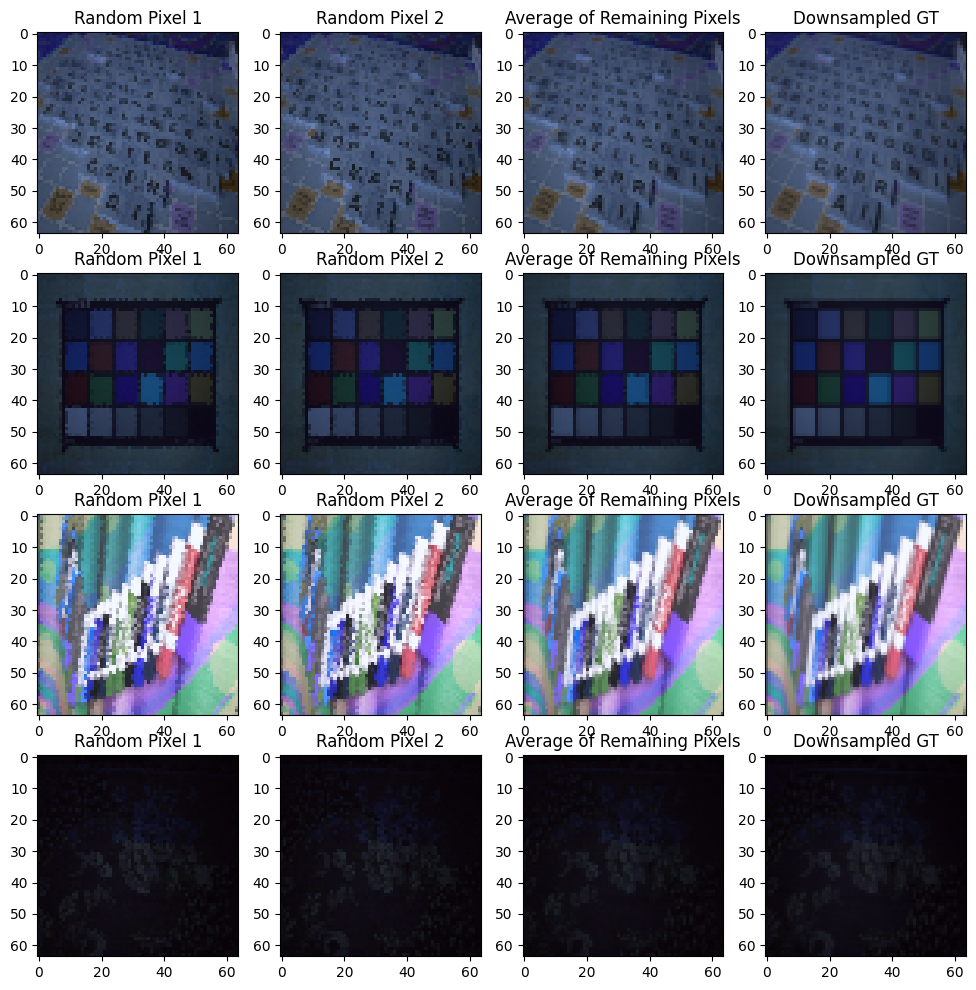

In [3]:

img_size = 128
batch_size = 32


# Prepare dataset and dataloader
dataset = SIDD_Dataset(noisy_img_array, gt_img_array, img_size=img_size)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get one batch of data
data_iter = iter(dataloader)
img1, img2, img3, downsampled_gt = next(data_iter)

# Display the images in the batch
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    axes[i, 0].imshow(img1[i].permute(1, 2, 0).numpy())
    axes[i, 0].set_title('Random Pixel 1')
    axes[i, 1].imshow(img2[i].permute(1, 2, 0).numpy())
    axes[i, 1].set_title('Random Pixel 2')
    axes[i, 2].imshow(img3[i].permute(1, 2, 0).numpy())
    axes[i, 2].set_title('Average of Remaining Pixels')
    axes[i, 3].imshow(downsampled_gt[i].permute(1, 2, 0).numpy())
    axes[i, 3].set_title('Downsampled GT')
plt.show()

In [4]:
# DnCNN 모델 정의
class DnCNN(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, num_layers=17, features=64):
        """
        DnCNN 모델 (2개의 입력 이미지를 concat하여 1개의 타겟 이미지 예측)
        
        Args:
            in_channels (int): 입력 채널 수 (2개의 RGB 이미지 concat -> 6)
            out_channels (int): 출력 채널 수 (RGB 이미지 -> 3)
            num_layers (int): 레이어 수
            features (int): 특징 맵 수
        """
        super(DnCNN, self).__init__()
        
        layers = []
        
        # 첫 번째 레이어: Conv + ReLU
        layers.append(nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))
        
        # 중간 레이어: Conv + BN + ReLU
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        
        # 마지막 레이어: Conv
        layers.append(nn.Conv2d(features, out_channels, kernel_size=3, padding=1, bias=True))
        
        self.dncnn = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        순전파
        
        Args:
            x: 입력 이미지 텐서 (B, 6, H, W) - 2개의 RGB 이미지 concat
            
        Returns:
            출력 이미지 텐서 (B, 3, H, W)
        """
        return self.dncnn(x)
    
# DnCNN 모델 정의
class DnCNN_CA(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, num_layers=15, features=64):
        """
        DnCNN 모델 (2개의 입력 이미지를 concat하여 1개의 타겟 이미지 예측)
        
        Args:
            in_channels (int): 입력 채널 수 (2개의 RGB 이미지 concat -> 6)
            out_channels (int): 출력 채널 수 (RGB 이미지 -> 3)
            num_layers (int): 레이어 수
            features (int): 특징 맵 수
        """
        super(DnCNN_CA, self).__init__()
        
        layers = []
        
        # 첫 번째 레이어: Conv + ReLU
        layers.append(nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))
        
        # 중간 레이어: Conv + BN + ReLU
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        
        
        # 마지막 레이어: Conv
        # layers.append(nn.Conv2d(features, out_channels, kernel_size=3, padding=1, bias=True))
        
        self.dncnn = nn.Sequential(*layers)
        
        # Cross Attention을 위한 변환 레이어
        self.q_proj = nn.Conv2d(features // 2, features // 2, kernel_size=1)
        self.k_proj = nn.Conv2d(features // 2, features // 2, kernel_size=1)
        self.v_proj = nn.Conv2d(features // 2, features // 2, kernel_size=1)
        
        # 출력 조정을 위한 레이어
        self.out_proj = nn.Conv2d(features, features, kernel_size=1)
        
        
        
        self.last_layer = nn.Conv2d(features, out_channels, kernel_size=3, padding=1, bias=True)
    
    def forward(self, x):
        """
        순전파
        
        Args:
            x: 입력 이미지 텐서 (B, 6, H, W) - 2개의 RGB 이미지 concat
            
        Returns:
            출력 이미지 텐서 (B, 3, H, W)
        """
        x = self.dncnn(x)
        
         # 채널 축으로 반으로 나눔
        features_half = x.shape[1] // 2
        q_features = x[:, :features_half, ...]  # (B, features/2, H, W)
        k = x[:, features_half:, ...]  # (B, features/2, H, W)
        
        # Q, K, V 변환
        q = self.q_proj(q_features)  # (B, features/2, H, W)
        k = self.k_proj(k)  # (B, features/2, H, W)
        v = self.v_proj(k)  # (B, features/2, H, W)
        
        # 어텐션 계산을 위한 형태 변환
        batch_size, C, height, width = q.shape
        q = q.view(batch_size, C, height * width).permute(0, 2, 1)  # (B, H*W, C)
        k = k.view(batch_size, C, height * width)  # (B, C, H*W)
        v = v.view(batch_size, C, height * width).permute(0, 2, 1)  # (B, H*W, C)
        
        # 어텐션 가중치 계산
        attn_weights = torch.matmul(q, k) / (C ** 0.5)  # (B, H*W, H*W)
        attn_weights = F.softmax(attn_weights, dim=-1)
        
        # 어텐션 적용
        attn_weights = torch.matmul(attn_weights, v)  # (B, H*W, C)
        attn_weights = attn_weights.permute(0, 2, 1).view(batch_size, C, height, width)  # (B, C, H, W)
        
        # 원래 특징맵과 결합
        x = torch.cat([q_features, attn_weights], dim=1)  # (B, features, H, W)
        
        # 출력 조정
        x = self.out_proj(x)  # (B, features, H, W)
        
        
        x = self.last_layer(x)
        
        return x

In [5]:
# PSNR calculation
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))

# 시각화 함수
def visualize_input_target_output(model, dataloader, device, num_samples=2):
    """모델의 입력, 타겟, 출력을 시각화합니다"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 5, figsize=(16, 4*num_samples))
    
    with torch.no_grad():
        for i, (input1, input2, targets, cleans) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            input1 = input1.to(device)
            input2 = input2.to(device)
            targets = targets.to(device)
            cleans = cleans.to(device)
            
            # 모델 예측
            inputs = torch.cat((input1, input2), dim=1)
            outputs = model(inputs)
            
            # 시각화
            # 입력 이미지 1 (채널 0-2)
            axes[i, 0].imshow(input1[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            axes[i, 0].set_title('Input Image 1')
            axes[i, 0].axis('off')
            
            # 입력 이미지 2 (채널 3-5)
            axes[i, 1].imshow(input2[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            axes[i, 1].set_title('Input Image 2')
            axes[i, 1].axis('off')
            
            # 타겟 이미지
            axes[i, 2].imshow(targets[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            axes[i, 2].set_title('Target Image')
            axes[i, 2].axis('off')
            
            # 깨끗한 원본 이미지
            axes[i, 3].imshow(cleans[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            axes[i, 3].set_title('Clean Original Image')
            axes[i, 3].axis('off')
            
            # 출력 이미지
            axes[i, 4].imshow(outputs[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            
            # PSNR 계산
            mse = F.mse_loss(outputs[0], targets[0]).item()
            psnr = -10 * np.log10(mse) if mse > 0 else 100
            axes[i, 4].set_title(f'Output Image (PSNR: {psnr:.2f}dB)')
            axes[i, 4].axis('off')
    
    plt.tight_layout()
    plt.show()

# 학습 함수
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, ca=None):
    """
    DnCNN 모델 학습 함수
    
    Args:
        model: DnCNN 모델
        train_loader: 학습 데이터로더
        val_loader: 검증 데이터로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 에폭 수
        device: 학습 디바이스 (cuda 또는 cpu)
    """
    model.to(device)
    best_val_loss = float('inf')
    
    # 학습 기록
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        train_loss = 0.0
        
        # 학습
        for input1, input2, targets, cleans in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            input1, input2, targets, cleans = input1.to(device), input2.to(device), targets.to(device), cleans.to(device)
            inputs = torch.cat((input1, input2), dim=1)
            
            # 그래디언트 초기화
            optimizer.zero_grad()
            
            # 순전파
            outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 역전파
            loss.backward()
            
            # 가중치 업데이트
            optimizer.step()
            
            # 손실 누적
            train_loss += loss.item() * inputs.size(0)
        
        # 에폭 평균 손실
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        val_psnr = 0.0
        
        with torch.no_grad():
            for input1, input2, targets, cleans in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                input1, input2, targets, cleans = input1.to(device), input2.to(device), targets.to(device), cleans.to(device)
                inputs = torch.cat((input1, input2), dim=1)
                
                # 순전파
                outputs = model(inputs)
                
                # 손실 계산
                loss = criterion(outputs, targets)
                
                # 손실 누적
                val_loss += loss.item() * inputs.size(0)
                
                for i in range(outputs.size(0)):
                    # outputs와 cleans 비교 (targets 대신)
                    psnr = calculate_psnr(outputs[i], cleans[i])
                    val_psnr += psnr.item()  # 텐서를 스칼라로 변환
        
        # 에폭 평균 손실 및 PSNR
        val_loss = val_loss / len(val_loader.dataset)
        val_psnr = val_psnr / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val PSNR: {val_psnr:.2f}dB")
        
        # 모델 저장 (가장 좋은 검증 손실)
        if ca is not None:
            model_name = f'best_unet_model_{ca}.pth'
        else:
            model_name = f'best_unet_model.pth'
        model_path = os.path.join('./checkpoints', model_name)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"모델 저장됨 (Val Loss: {val_loss:.4f})")
        
        # 중간 결과 시각화 (5에폭마다)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            visualize_input_target_output(model, val_loader, device, num_samples=2)
    
    # 학습 곡선 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses

In [6]:

# 필요한 라이브러리 import
from thop import profile
import torch

# 모델 프로파일링
def measure_model_complexity(model, img_size=256, device='cuda'):
    """
    모델의 파라미터 수와 GFLOPs 계산
    
    Args:
        model: 파라미터 수와 GFLOPs를 계산할 모델
        
    Returns:
        tuple: (파라미터 수, GFLOPs)
    """
    model.to(device)
    params = sum(p.numel() for p in model.parameters())
    input_sample = torch.randn(1, 6, img_size, img_size).to(device)  # CIFAR-10 이미지 크기 (32x32)
    flops, _ = profile(model, inputs=(input_sample,))
    flops = flops / 1e9  # GFLOPs로 변환
    return params, flops

In [7]:

def main(num_epochs=50, batch_size=16, learning_rate=0.001, img_size=512, ca=None):
    """
    학습을 수행하는 메인 함수
    
    Args:
        num_epochs: 훈련 에폭 수
        batch_size: 배치 크기
        learning_rate: 학습률
        noise_level: 노이즈 수준 (모델 저장 파일명에 사용)
        img_size: 이미지 크기
        ca: None 또는 'ca' (채널 어텐션 사용 여부)
    """
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 중인 디바이스: {device}")
    
    # 체크포인트 디렉토리 생성
    os.makedirs('./checkpoints', exist_ok=True)
    
    # 데이터 로드
    print("SIDD 데이터셋 로드 중...")
    try:
        # 데이터셋 경로 설정 (실제 경로로 수정 필요)
        data_path = 'data'
        
        # 데이터 로드 (실제 데이터 로드 코드로 대체 필요)
        noisy_data = np.load(f'{data_path}/noisy_img_array.npy', mmap_mode='r')
        gt_data = np.load(f'{data_path}/gt_img_array.npy', mmap_mode='r')
        noisy_data = noisy_img_array.astype(np.float32) / 255.0
        gt_data = gt_img_array.astype(np.float32) / 255.0
        
        print(f"데이터 로드 완료: noisy shape {noisy_data.shape}, gt shape {gt_data.shape}")
        
        # 데이터셋 생성
        dataset = SIDD_Dataset(noisy_data, gt_data, img_size=img_size)
        
        # 학습/검증 분할
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        # 데이터로더 생성
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)
        
        print(f"학습 샘플 수: {len(train_dataset)}, 검증 샘플 수: {len(val_dataset)}")
        
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return
    
    # 모델 초기화
    print("모델 초기화 중...")
    if ca == 'ca':
        model = DnCNN_CA(in_channels=6, out_channels=3)
        print("채널 어텐션이 포함된 DnCNN 모델 생성됨")
    else:
        model = DnCNN(in_channels=6, out_channels=3)
        print("기본 DnCNN 모델 생성됨")
    
    # 모델 GFLOPs 계산
    # flops, params = measure_model_complexity(model, img_size=img_size, device=device)
    # flops, params = measure_model_complexity(model, img_size=img_size, device=device)
    # print(f"모델 GFLOPs: {flops / 1e9:.2f} GFLOPs")
    params = sum(p.numel() for p in model.parameters())
    print(f"모델 총 파라미터: {params:,}")
    
    # 옵티마이저 및 손실 함수 설정
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 학습 시작
    print(f"학습 시작 - {num_epochs} 에폭")
    train_losses, val_losses = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device,
        ca=ca,
    )
    
    # 최종 모델 저장
    if ca is not None:
        model_name = f'final_dncnn_model_{ca}.pth'
    else:
        model_name = f'final_dncnn_model.pth'
    model_path = os.path.join('./checkpoints', model_name)
    torch.save(model.state_dict(), model_path)
    print(f"최종 모델 저장 완료: {model_path}")
    
    # 최종 결과 시각화
    print("최종 결과 시각화 중...")
    model.eval()
    visualize_input_target_output(model, val_loader, device, num_samples=2)
    
    print("학습 및 평가 완료!")
    return model, train_losses, val_losses

사용 중인 디바이스: cuda
SIDD 데이터셋 로드 중...


C:\Users\pook0\AppData\Local\Temp\ipykernel_18708\2525196961.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(cache_file)


데이터 로드 완료: noisy shape (160, 1024, 1024, 3), gt shape (160, 1024, 1024, 3)
=== SIDD_Dataset 초기화 (img_size=128) ===
캐시 파일을 로드합니다: ./dataset_cache\sidd_processed_128.pt
캐시 로드 완료. 소요 시간: 0.01초
데이터 크기: 160 샘플, 이미지 크기: 64x64
학습 샘플 수: 128, 검증 샘플 수: 32
모델 초기화 중...
기본 DnCNN 모델 생성됨
모델 총 파라미터: 560,131
학습 시작 - 100 에폭


Epoch 1/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 120.29it/s]


Epoch 1/100 - Train Loss: 0.0983, Val Loss: 0.0488, Val PSNR: 16.41dB
모델 저장됨 (Val Loss: 0.0488)


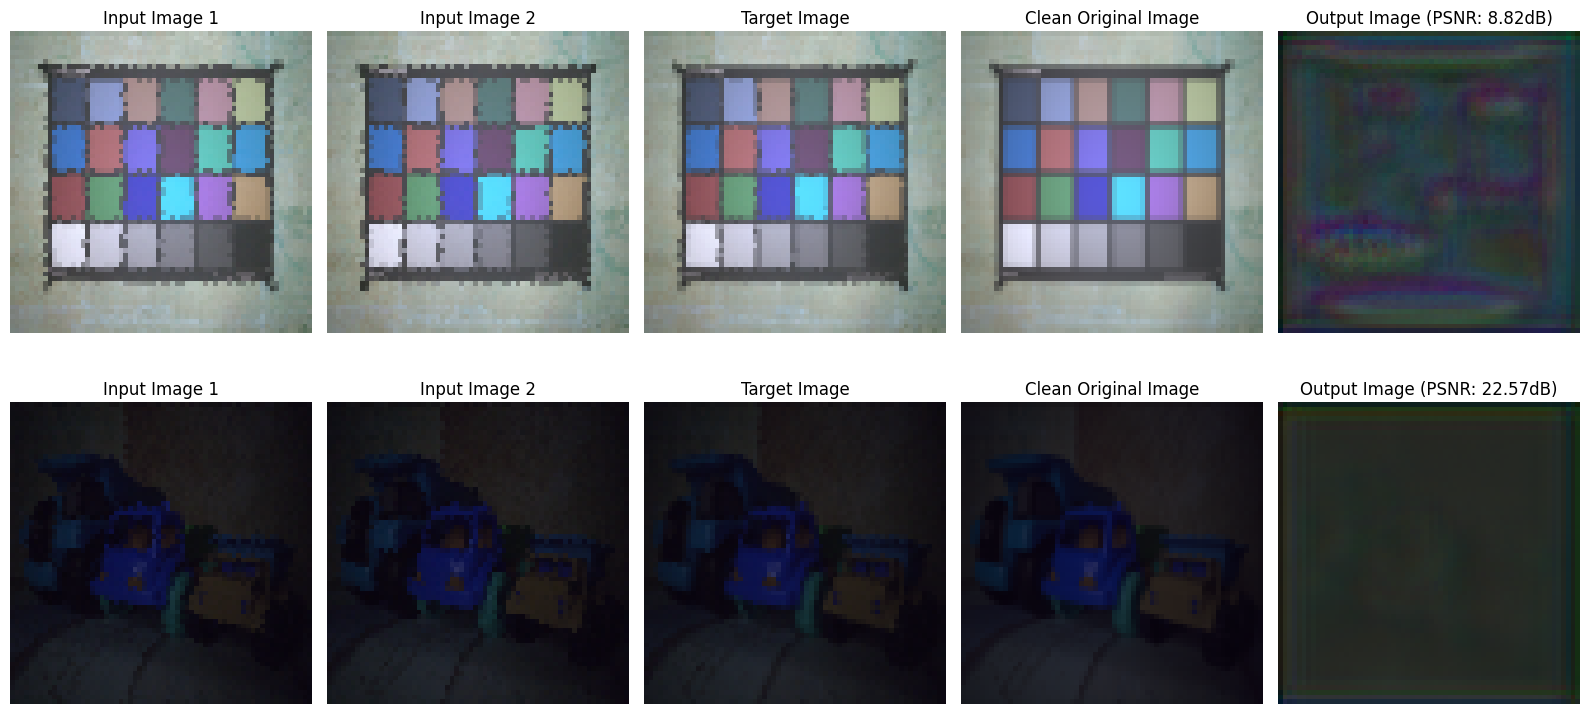

Epoch 2/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 329.42it/s]


Epoch 2/100 - Train Loss: 0.0220, Val Loss: 0.0121, Val PSNR: 21.15dB
모델 저장됨 (Val Loss: 0.0121)


Epoch 3/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 285.74it/s]


Epoch 3/100 - Train Loss: 0.0184, Val Loss: 0.0104, Val PSNR: 21.88dB
모델 저장됨 (Val Loss: 0.0104)


Epoch 4/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.32it/s]


Epoch 4/100 - Train Loss: 0.0150, Val Loss: 0.0082, Val PSNR: 21.80dB
모델 저장됨 (Val Loss: 0.0082)


Epoch 5/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 320.00it/s]


Epoch 5/100 - Train Loss: 0.0156, Val Loss: 0.0104, Val PSNR: 22.67dB


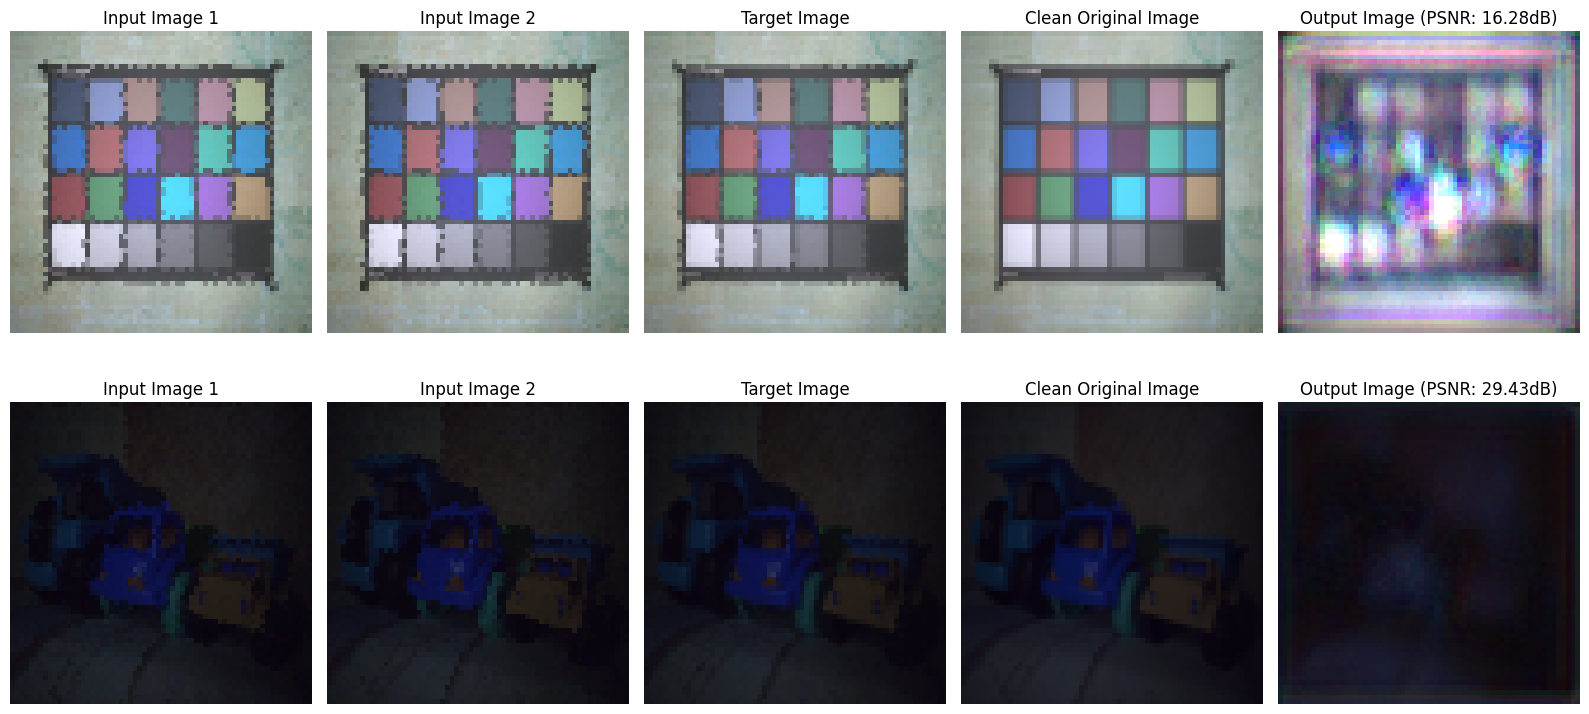

Epoch 6/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 301.76it/s]


Epoch 6/100 - Train Loss: 0.0134, Val Loss: 0.0073, Val PSNR: 22.82dB
모델 저장됨 (Val Loss: 0.0073)


Epoch 7/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 313.64it/s]


Epoch 7/100 - Train Loss: 0.0125, Val Loss: 0.0068, Val PSNR: 23.66dB
모델 저장됨 (Val Loss: 0.0068)


Epoch 8/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 318.79it/s]


Epoch 8/100 - Train Loss: 0.0138, Val Loss: 0.0095, Val PSNR: 22.55dB


Epoch 9/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 219.09it/s]


Epoch 9/100 - Train Loss: 0.0128, Val Loss: 0.0154, Val PSNR: 21.93dB


Epoch 10/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 326.35it/s]


Epoch 10/100 - Train Loss: 0.0107, Val Loss: 0.0071, Val PSNR: 23.82dB


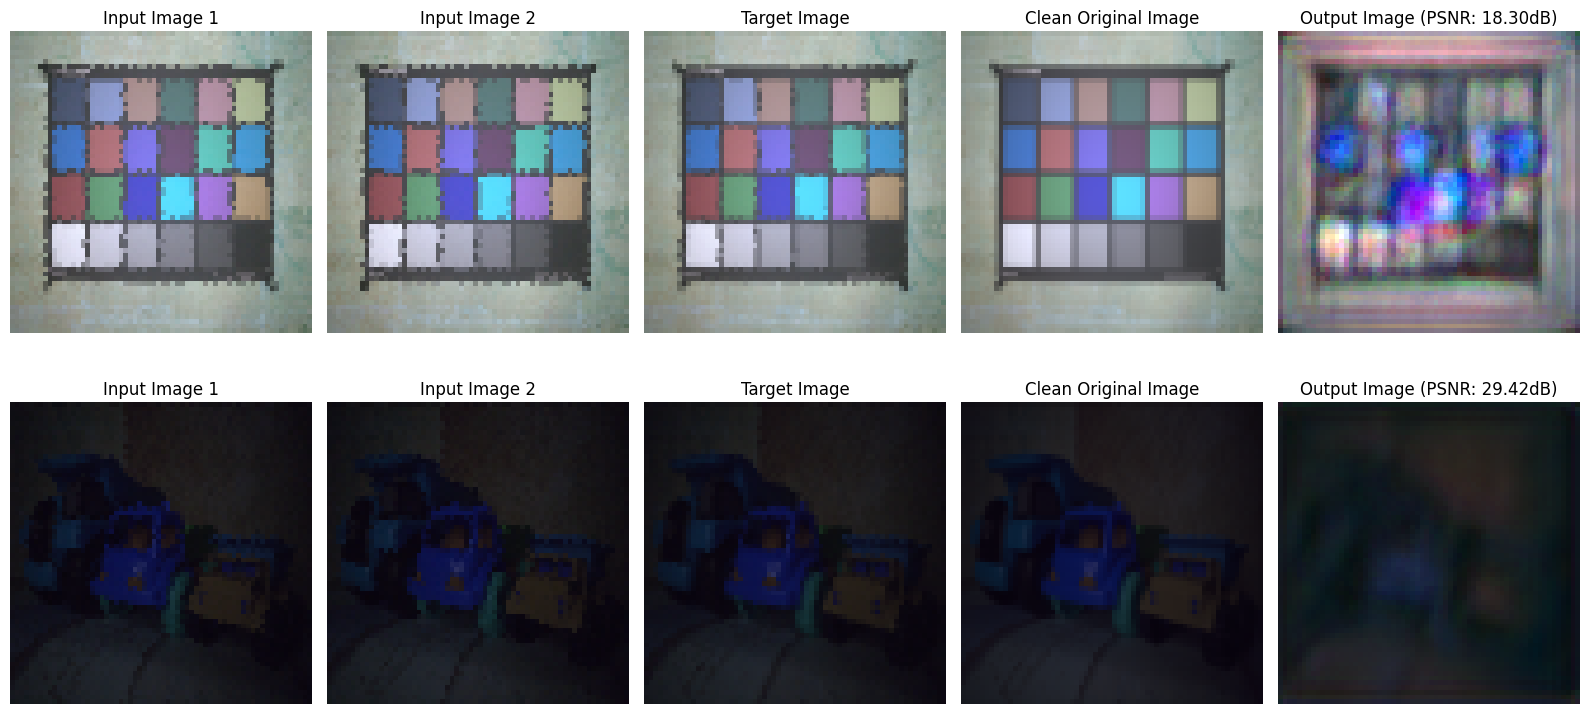

Epoch 11/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 285.72it/s]


Epoch 11/100 - Train Loss: 0.0097, Val Loss: 0.0089, Val PSNR: 22.65dB


Epoch 12/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 250.02it/s]


Epoch 12/100 - Train Loss: 0.0093, Val Loss: 0.0067, Val PSNR: 24.11dB
모델 저장됨 (Val Loss: 0.0067)


Epoch 13/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.97it/s]


Epoch 13/100 - Train Loss: 0.0093, Val Loss: 0.0143, Val PSNR: 22.43dB


Epoch 14/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 250.00it/s]


Epoch 14/100 - Train Loss: 0.0081, Val Loss: 0.0095, Val PSNR: 23.14dB


Epoch 15/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 275.85it/s]


Epoch 15/100 - Train Loss: 0.0075, Val Loss: 0.0057, Val PSNR: 24.40dB
모델 저장됨 (Val Loss: 0.0057)


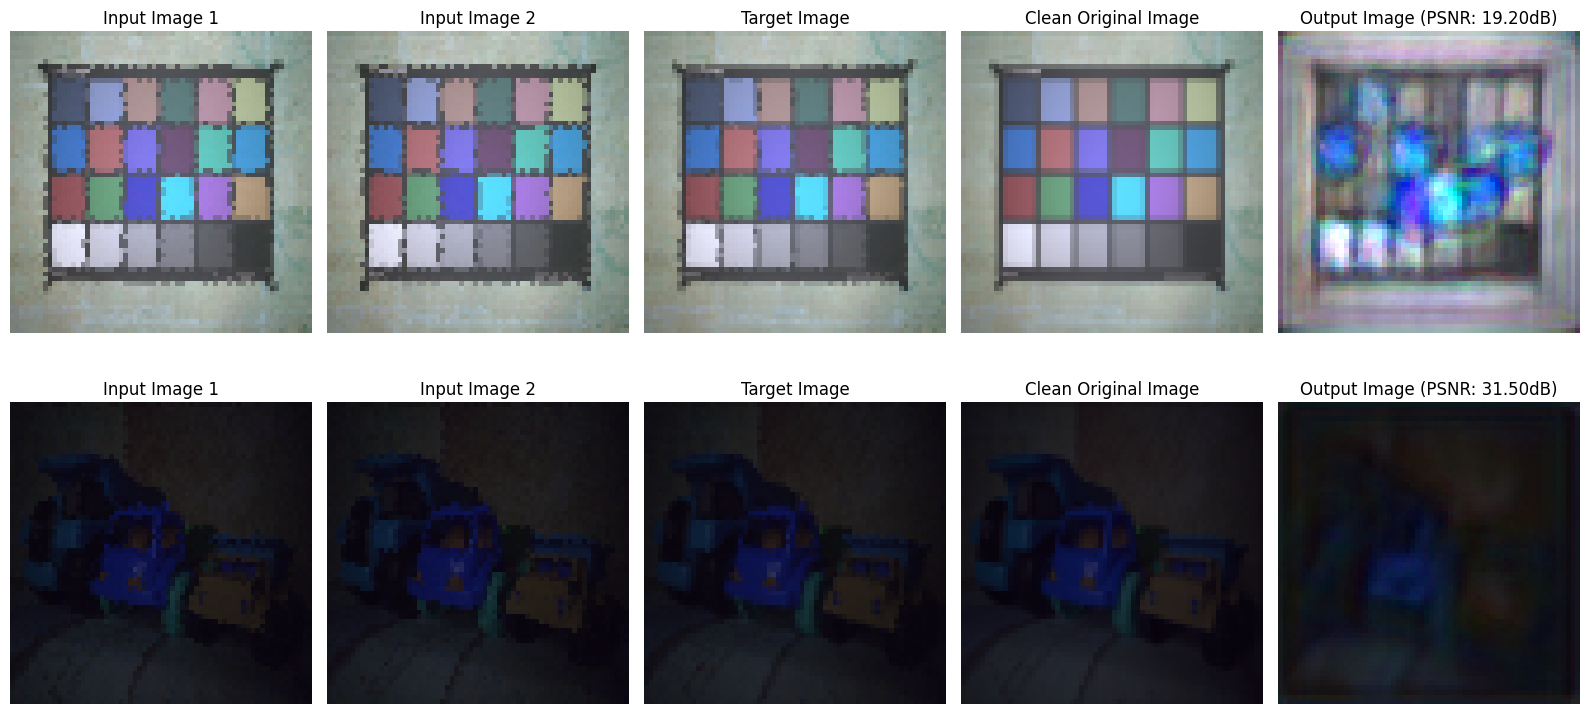

Epoch 16/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.34it/s]


Epoch 16/100 - Train Loss: 0.0083, Val Loss: 0.0057, Val PSNR: 24.34dB
모델 저장됨 (Val Loss: 0.0057)


Epoch 17/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 266.68it/s]


Epoch 17/100 - Train Loss: 0.0071, Val Loss: 0.0083, Val PSNR: 23.53dB


Epoch 18/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 228.57it/s]


Epoch 18/100 - Train Loss: 0.0078, Val Loss: 0.0081, Val PSNR: 24.04dB


Epoch 19/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 250.00it/s]


Epoch 19/100 - Train Loss: 0.0068, Val Loss: 0.0043, Val PSNR: 25.54dB
모델 저장됨 (Val Loss: 0.0043)


Epoch 20/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.97it/s]


Epoch 20/100 - Train Loss: 0.0073, Val Loss: 0.0045, Val PSNR: 25.21dB


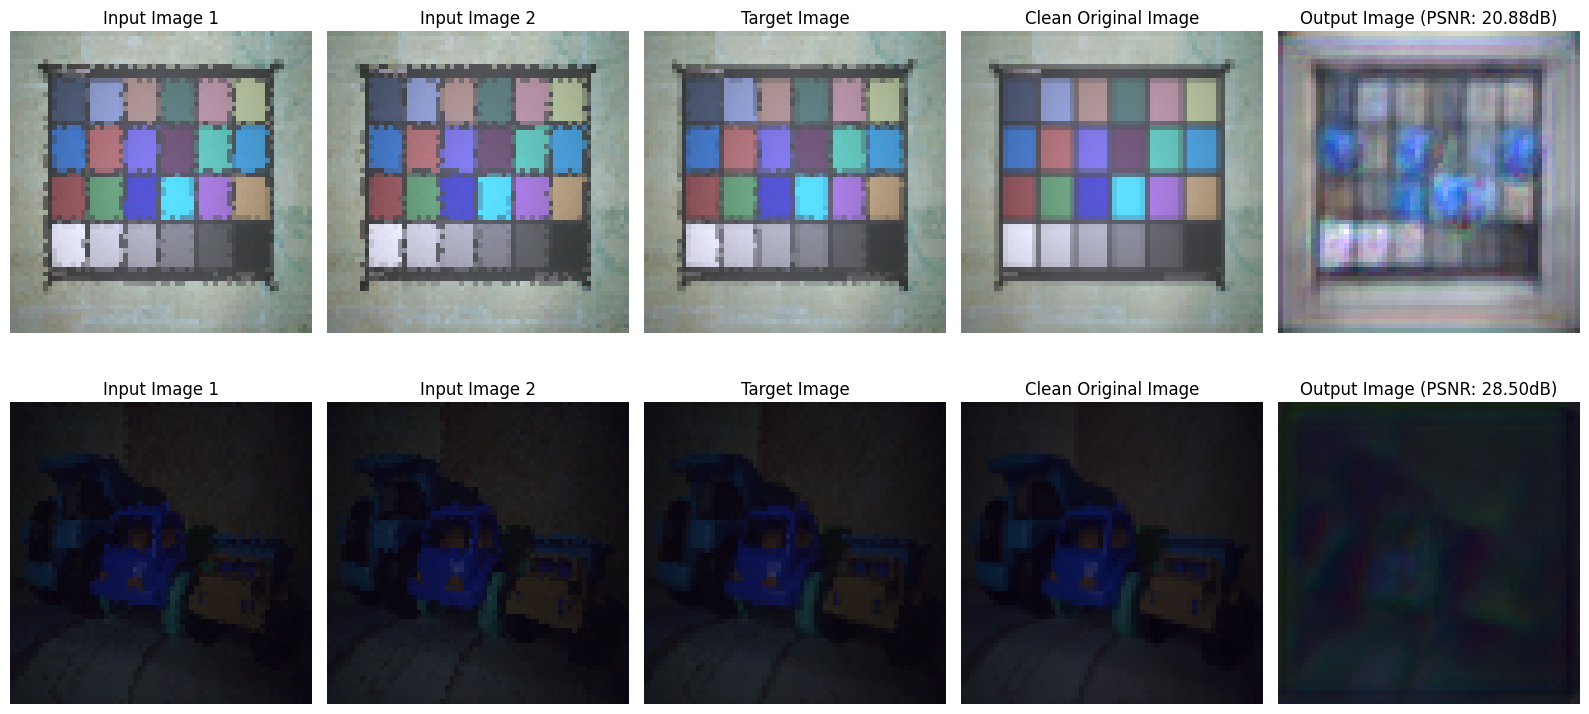

Epoch 21/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 285.73it/s]


Epoch 21/100 - Train Loss: 0.0061, Val Loss: 0.0050, Val PSNR: 25.07dB


Epoch 22/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 347.83it/s]


Epoch 22/100 - Train Loss: 0.0053, Val Loss: 0.0074, Val PSNR: 24.04dB


Epoch 23/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.33it/s]


Epoch 23/100 - Train Loss: 0.0049, Val Loss: 0.0041, Val PSNR: 25.23dB
모델 저장됨 (Val Loss: 0.0041)


Epoch 24/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 232.31it/s]


Epoch 24/100 - Train Loss: 0.0053, Val Loss: 0.0052, Val PSNR: 25.32dB


Epoch 25/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.99it/s]


Epoch 25/100 - Train Loss: 0.0053, Val Loss: 0.0039, Val PSNR: 25.63dB
모델 저장됨 (Val Loss: 0.0039)


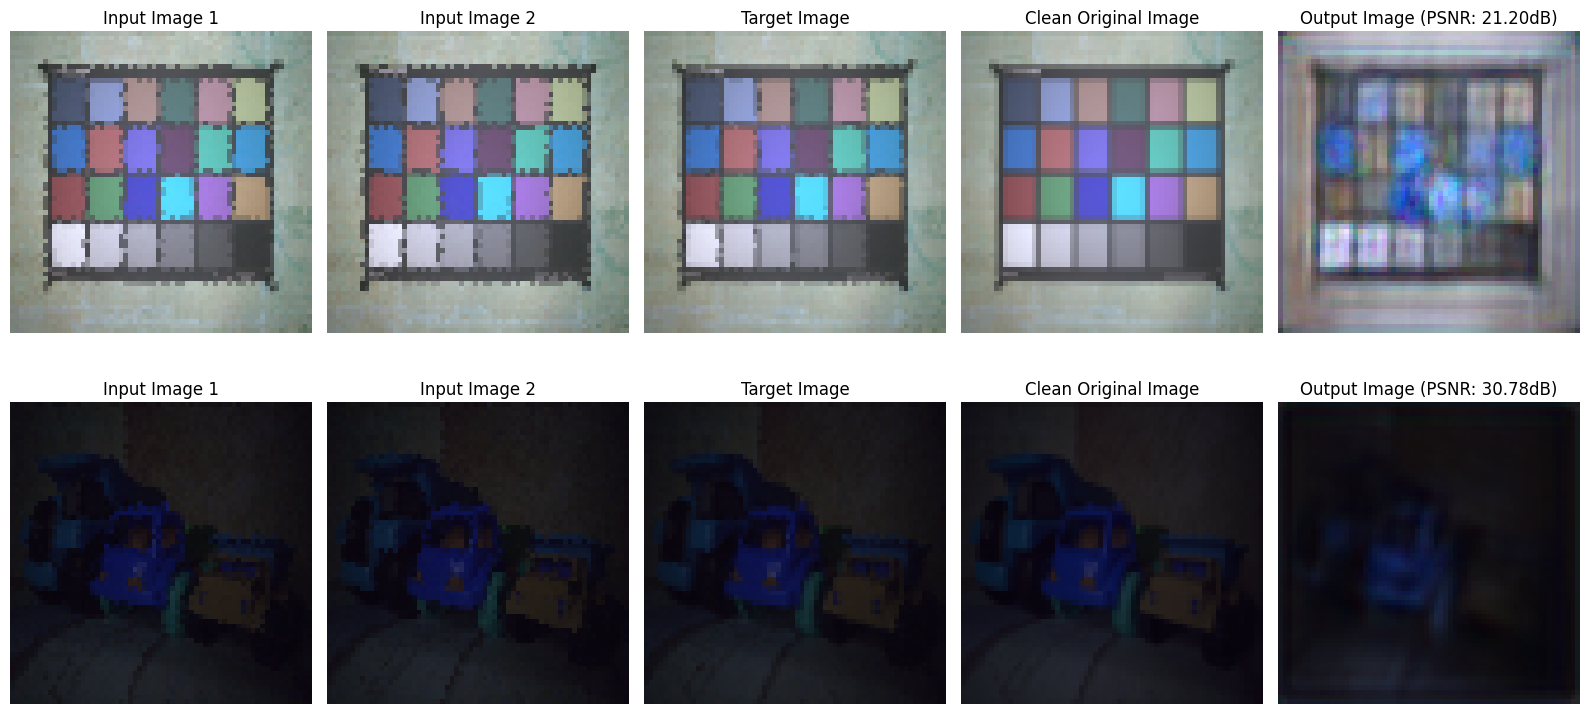

Epoch 26/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 275.88it/s]


Epoch 26/100 - Train Loss: 0.0059, Val Loss: 0.0068, Val PSNR: 23.92dB


Epoch 27/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.36it/s]


Epoch 27/100 - Train Loss: 0.0060, Val Loss: 0.0040, Val PSNR: 25.50dB


Epoch 28/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 320.00it/s]


Epoch 28/100 - Train Loss: 0.0055, Val Loss: 0.0043, Val PSNR: 25.85dB


Epoch 29/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.34it/s]


Epoch 29/100 - Train Loss: 0.0045, Val Loss: 0.0049, Val PSNR: 25.38dB


Epoch 30/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.38it/s]


Epoch 30/100 - Train Loss: 0.0046, Val Loss: 0.0046, Val PSNR: 24.68dB


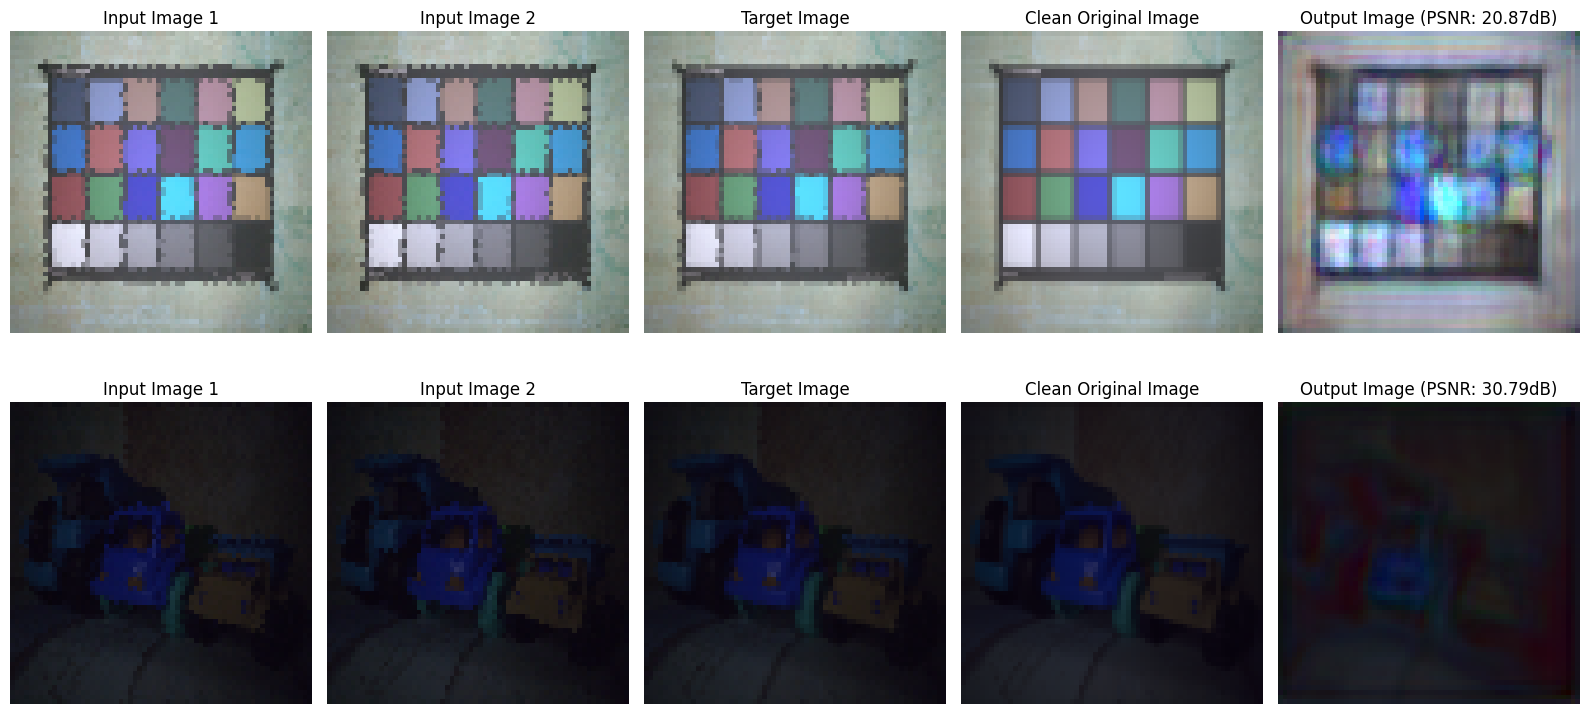

Epoch 31/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.98it/s]


Epoch 31/100 - Train Loss: 0.0045, Val Loss: 0.0050, Val PSNR: 25.48dB


Epoch 32/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.34it/s]


Epoch 32/100 - Train Loss: 0.0054, Val Loss: 0.0046, Val PSNR: 25.09dB


Epoch 33/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.31it/s]


Epoch 33/100 - Train Loss: 0.0047, Val Loss: 0.0042, Val PSNR: 26.04dB


Epoch 34/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.31it/s]


Epoch 34/100 - Train Loss: 0.0046, Val Loss: 0.0057, Val PSNR: 25.35dB


Epoch 35/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 320.04it/s]


Epoch 35/100 - Train Loss: 0.0044, Val Loss: 0.0039, Val PSNR: 26.01dB


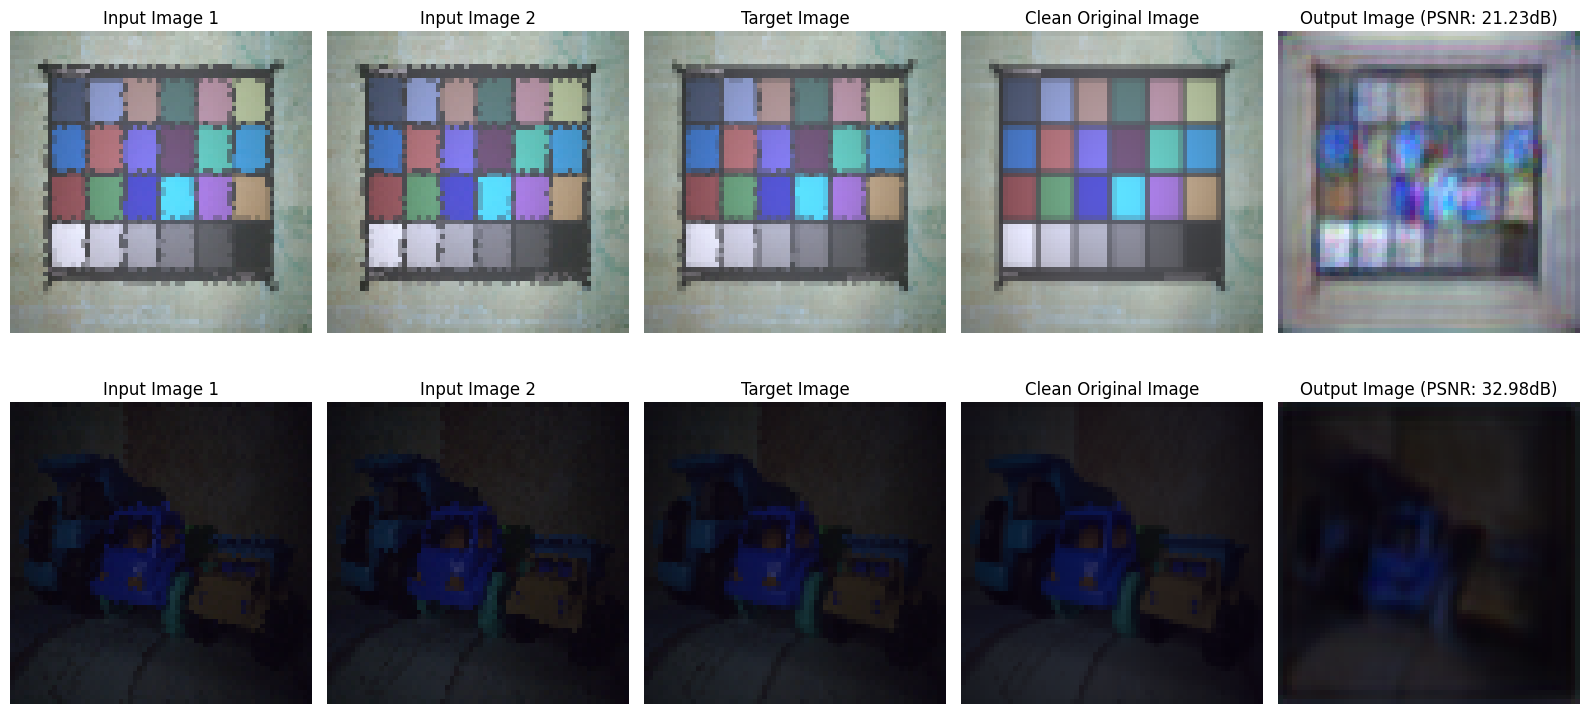

Epoch 36/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.78it/s]


Epoch 36/100 - Train Loss: 0.0050, Val Loss: 0.0044, Val PSNR: 26.02dB


Epoch 37/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 283.81it/s]


Epoch 37/100 - Train Loss: 0.0045, Val Loss: 0.0038, Val PSNR: 26.16dB
모델 저장됨 (Val Loss: 0.0038)


Epoch 38/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 275.88it/s]


Epoch 38/100 - Train Loss: 0.0044, Val Loss: 0.0035, Val PSNR: 26.59dB
모델 저장됨 (Val Loss: 0.0035)


Epoch 39/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.34it/s]


Epoch 39/100 - Train Loss: 0.0047, Val Loss: 0.0044, Val PSNR: 24.90dB


Epoch 40/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 222.23it/s]


Epoch 40/100 - Train Loss: 0.0042, Val Loss: 0.0044, Val PSNR: 25.66dB


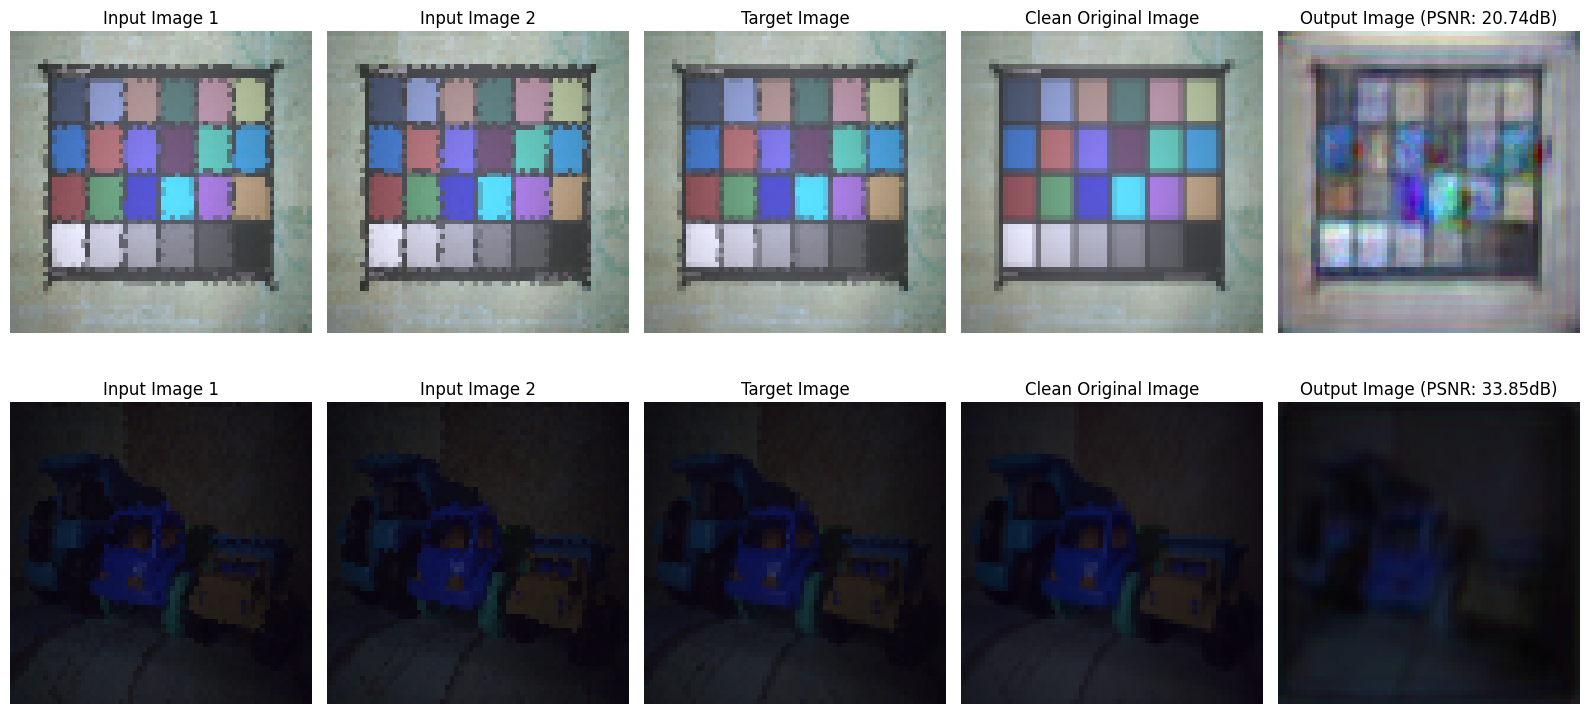

Epoch 41/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 290.79it/s]


Epoch 41/100 - Train Loss: 0.0040, Val Loss: 0.0038, Val PSNR: 26.47dB


Epoch 42/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 326.43it/s]


Epoch 42/100 - Train Loss: 0.0038, Val Loss: 0.0035, Val PSNR: 26.43dB


Epoch 43/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 290.87it/s]


Epoch 43/100 - Train Loss: 0.0037, Val Loss: 0.0048, Val PSNR: 25.59dB


Epoch 44/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 316.64it/s]


Epoch 44/100 - Train Loss: 0.0044, Val Loss: 0.0047, Val PSNR: 25.99dB


Epoch 45/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.31it/s]


Epoch 45/100 - Train Loss: 0.0037, Val Loss: 0.0042, Val PSNR: 26.31dB


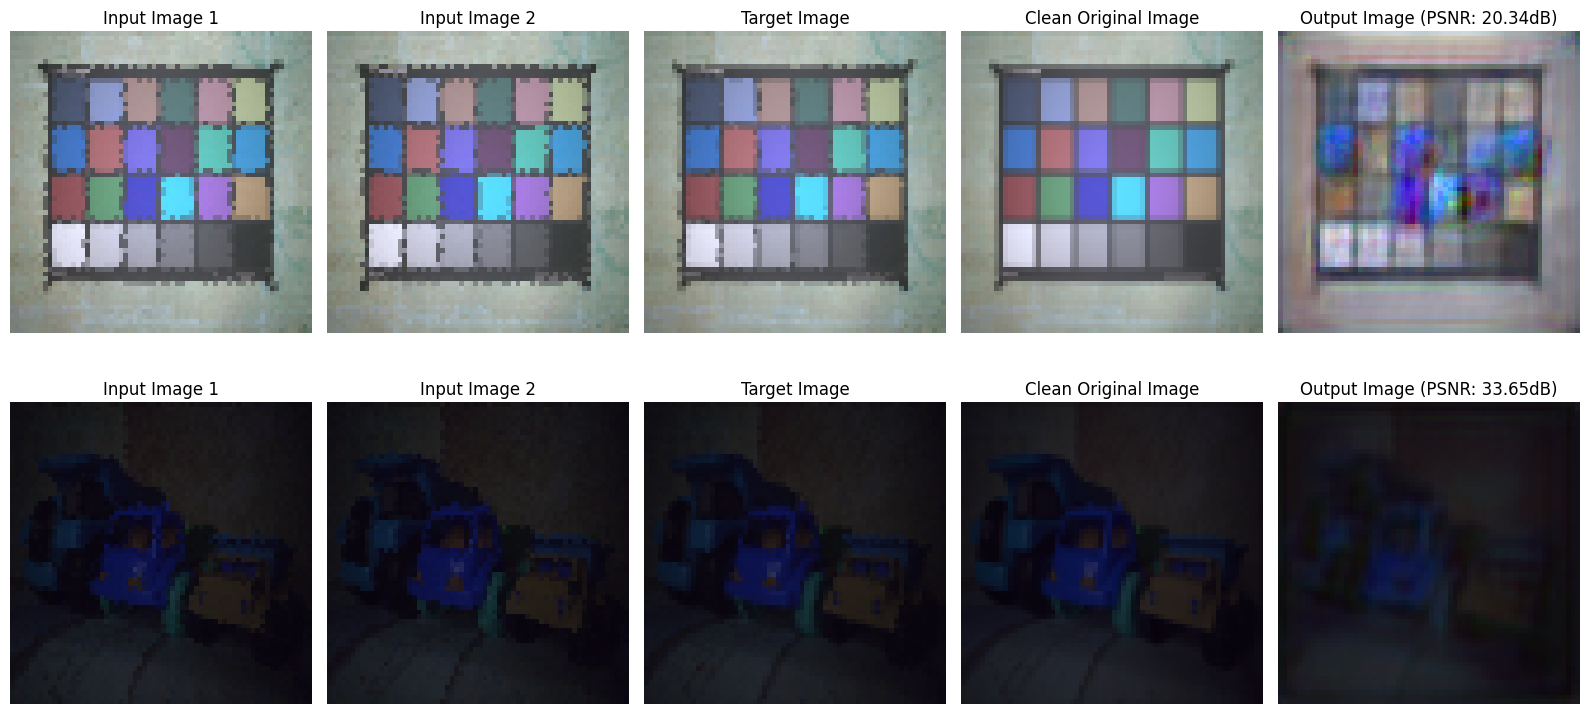

Epoch 46/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 307.71it/s]


Epoch 46/100 - Train Loss: 0.0037, Val Loss: 0.0036, Val PSNR: 26.35dB


Epoch 47/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.99it/s]


Epoch 47/100 - Train Loss: 0.0035, Val Loss: 0.0032, Val PSNR: 25.92dB
모델 저장됨 (Val Loss: 0.0032)


Epoch 48/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.33it/s]


Epoch 48/100 - Train Loss: 0.0039, Val Loss: 0.0035, Val PSNR: 25.92dB


Epoch 49/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 320.02it/s]


Epoch 49/100 - Train Loss: 0.0041, Val Loss: 0.0032, Val PSNR: 26.59dB
모델 저장됨 (Val Loss: 0.0032)


Epoch 50/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 307.72it/s]


Epoch 50/100 - Train Loss: 0.0036, Val Loss: 0.0048, Val PSNR: 25.46dB


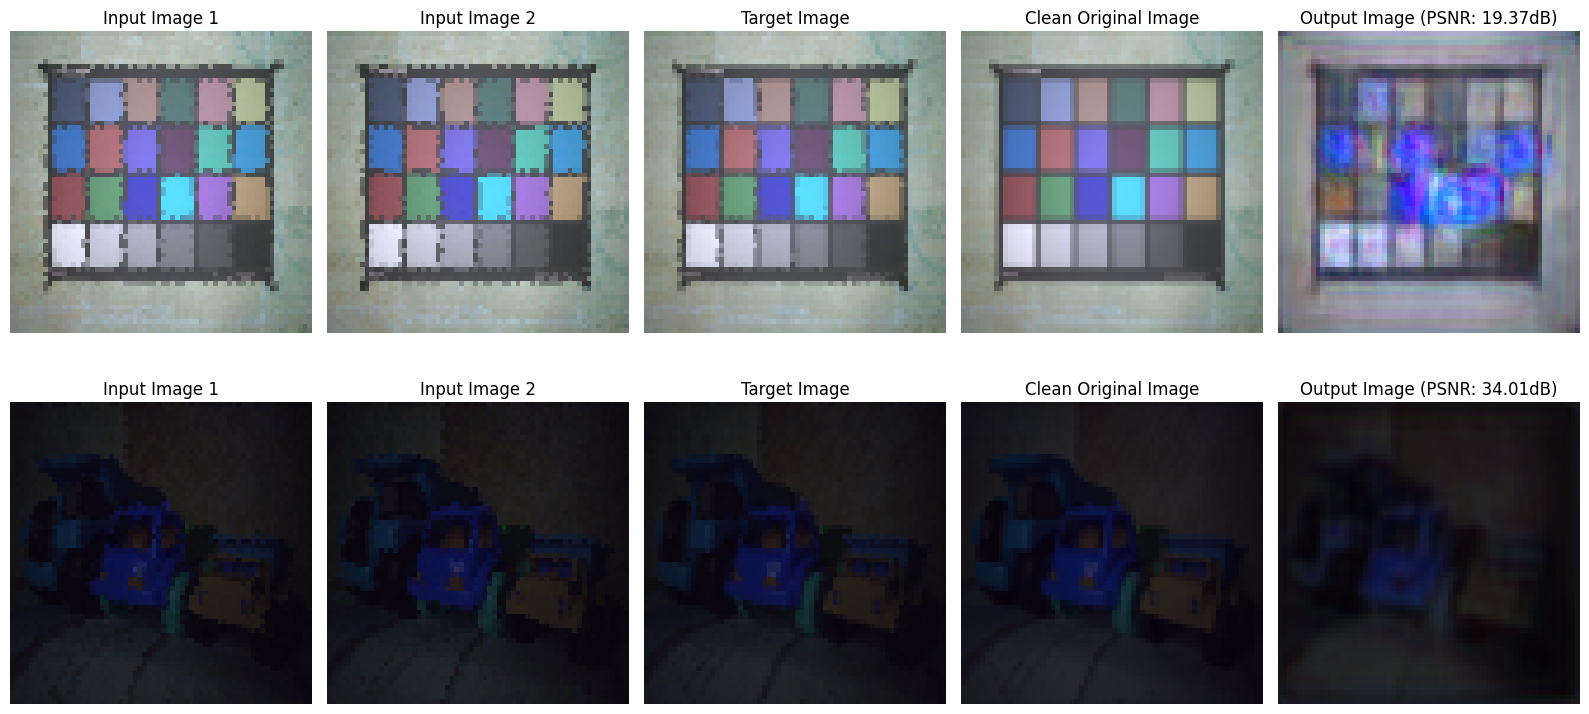

Epoch 51/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 307.68it/s]


Epoch 51/100 - Train Loss: 0.0044, Val Loss: 0.0087, Val PSNR: 24.07dB


Epoch 52/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 320.02it/s]


Epoch 52/100 - Train Loss: 0.0037, Val Loss: 0.0042, Val PSNR: 26.22dB


Epoch 53/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 244.81it/s]


Epoch 53/100 - Train Loss: 0.0034, Val Loss: 0.0037, Val PSNR: 26.82dB


Epoch 54/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.27it/s]


Epoch 54/100 - Train Loss: 0.0033, Val Loss: 0.0042, Val PSNR: 25.34dB


Epoch 55/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.97it/s]


Epoch 55/100 - Train Loss: 0.0036, Val Loss: 0.0029, Val PSNR: 26.82dB
모델 저장됨 (Val Loss: 0.0029)


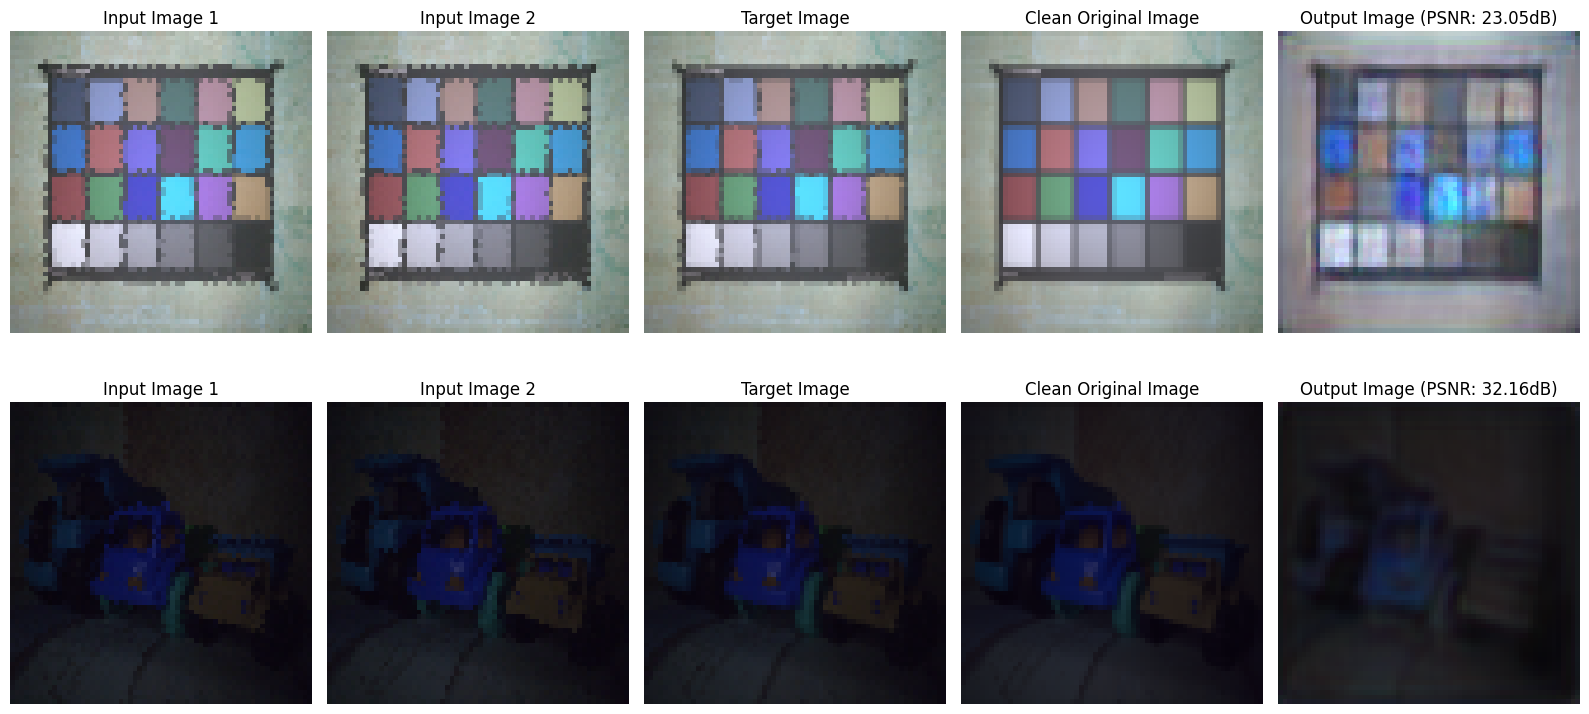

Epoch 56/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 285.72it/s]


Epoch 56/100 - Train Loss: 0.0034, Val Loss: 0.0031, Val PSNR: 27.14dB


Epoch 57/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 347.80it/s]


Epoch 57/100 - Train Loss: 0.0034, Val Loss: 0.0031, Val PSNR: 27.15dB


Epoch 58/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.35it/s]


Epoch 58/100 - Train Loss: 0.0036, Val Loss: 0.0030, Val PSNR: 27.57dB


Epoch 59/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.35it/s]


Epoch 59/100 - Train Loss: 0.0032, Val Loss: 0.0035, Val PSNR: 26.39dB


Epoch 60/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.30it/s]


Epoch 60/100 - Train Loss: 0.0038, Val Loss: 0.0060, Val PSNR: 25.13dB


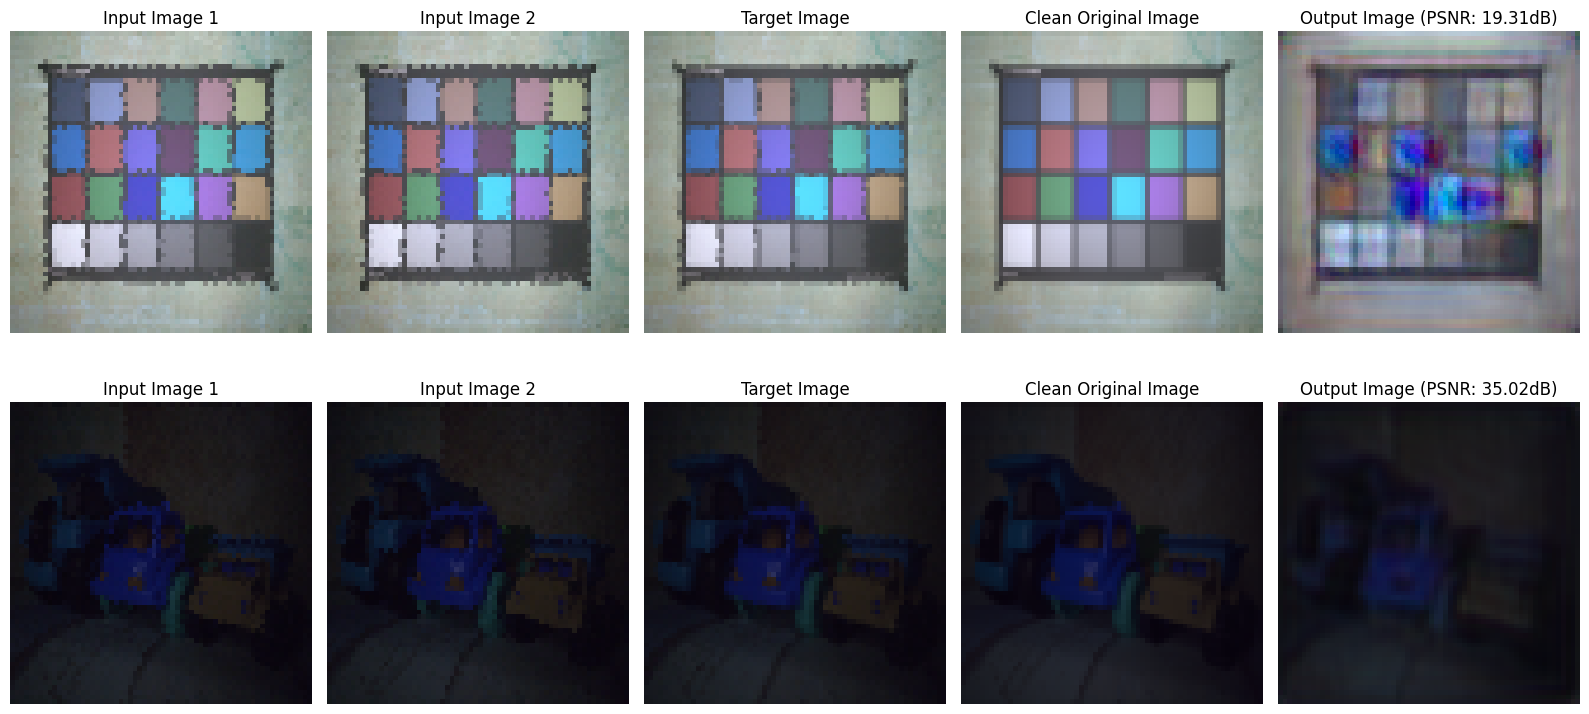

Epoch 61/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 290.80it/s]


Epoch 61/100 - Train Loss: 0.0048, Val Loss: 0.0053, Val PSNR: 25.19dB


Epoch 62/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.38it/s]


Epoch 62/100 - Train Loss: 0.0050, Val Loss: 0.0042, Val PSNR: 25.71dB


Epoch 63/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 313.63it/s]


Epoch 63/100 - Train Loss: 0.0036, Val Loss: 0.0035, Val PSNR: 26.40dB


Epoch 64/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 222.22it/s]


Epoch 64/100 - Train Loss: 0.0031, Val Loss: 0.0031, Val PSNR: 26.76dB


Epoch 65/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 347.85it/s]


Epoch 65/100 - Train Loss: 0.0032, Val Loss: 0.0028, Val PSNR: 27.50dB
모델 저장됨 (Val Loss: 0.0028)


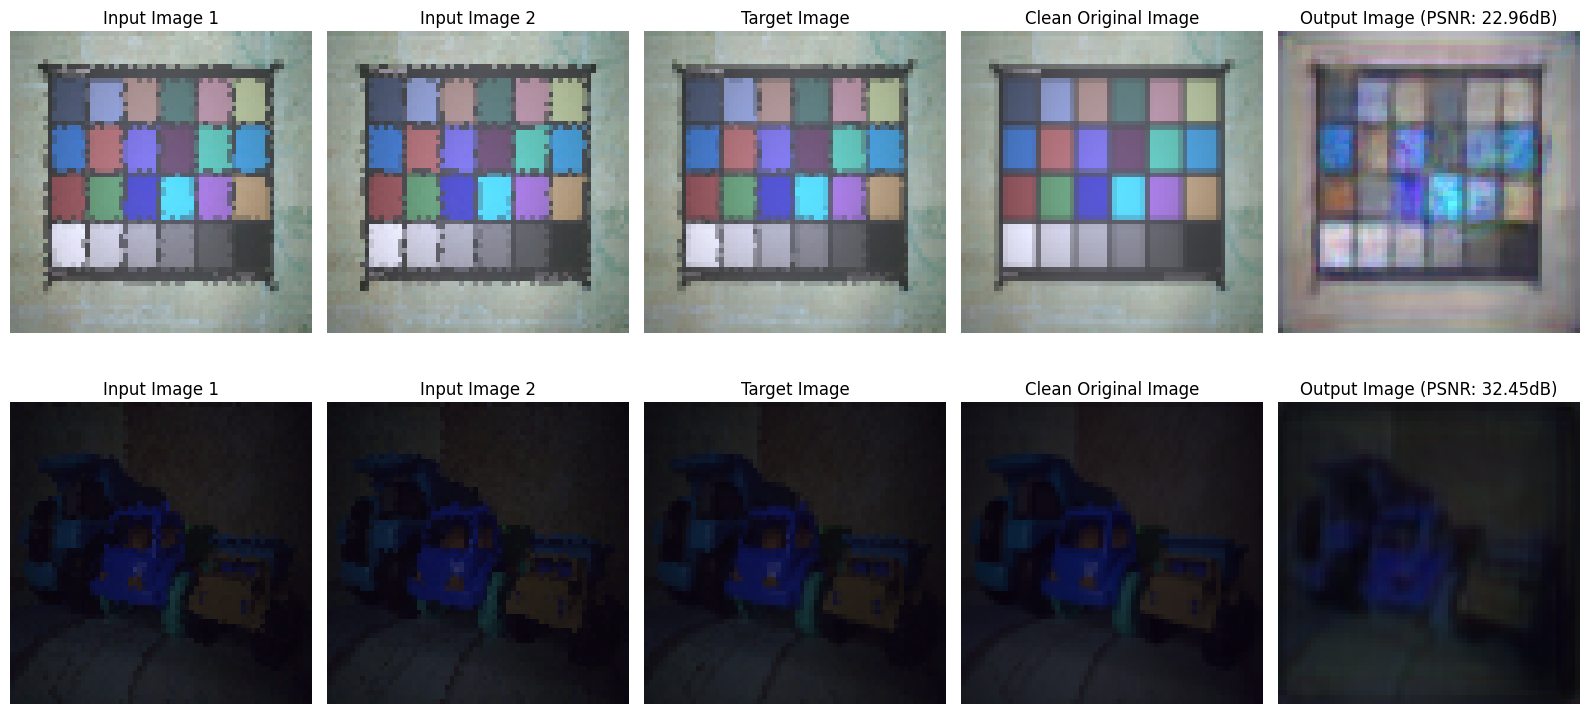

Epoch 66/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 320.06it/s]


Epoch 66/100 - Train Loss: 0.0032, Val Loss: 0.0026, Val PSNR: 27.62dB
모델 저장됨 (Val Loss: 0.0026)


Epoch 67/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 335.02it/s]


Epoch 67/100 - Train Loss: 0.0037, Val Loss: 0.0033, Val PSNR: 26.38dB


Epoch 68/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 326.44it/s]


Epoch 68/100 - Train Loss: 0.0033, Val Loss: 0.0031, Val PSNR: 26.52dB


Epoch 69/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.30it/s]


Epoch 69/100 - Train Loss: 0.0031, Val Loss: 0.0037, Val PSNR: 26.77dB


Epoch 70/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.09it/s]


Epoch 70/100 - Train Loss: 0.0031, Val Loss: 0.0030, Val PSNR: 27.52dB


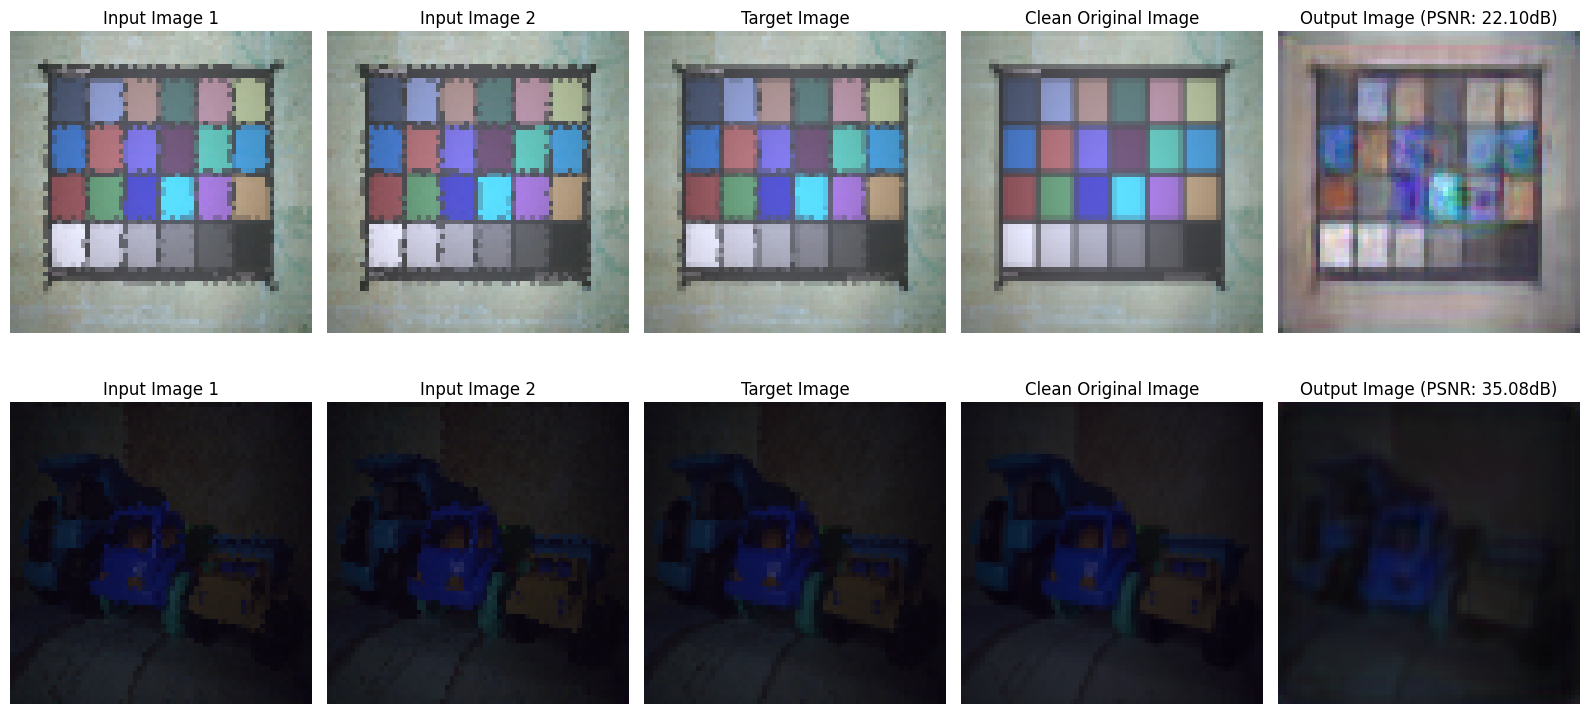

Epoch 71/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.35it/s]


Epoch 71/100 - Train Loss: 0.0028, Val Loss: 0.0026, Val PSNR: 27.84dB
모델 저장됨 (Val Loss: 0.0026)


Epoch 72/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.97it/s]


Epoch 72/100 - Train Loss: 0.0031, Val Loss: 0.0032, Val PSNR: 27.01dB


Epoch 73/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 320.01it/s]


Epoch 73/100 - Train Loss: 0.0042, Val Loss: 5.9348, Val PSNR: 6.91dB


Epoch 74/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 275.86it/s]


Epoch 74/100 - Train Loss: 0.0074, Val Loss: 0.0063, Val PSNR: 24.37dB


Epoch 75/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.27it/s]


Epoch 75/100 - Train Loss: 0.0059, Val Loss: 0.0044, Val PSNR: 25.15dB


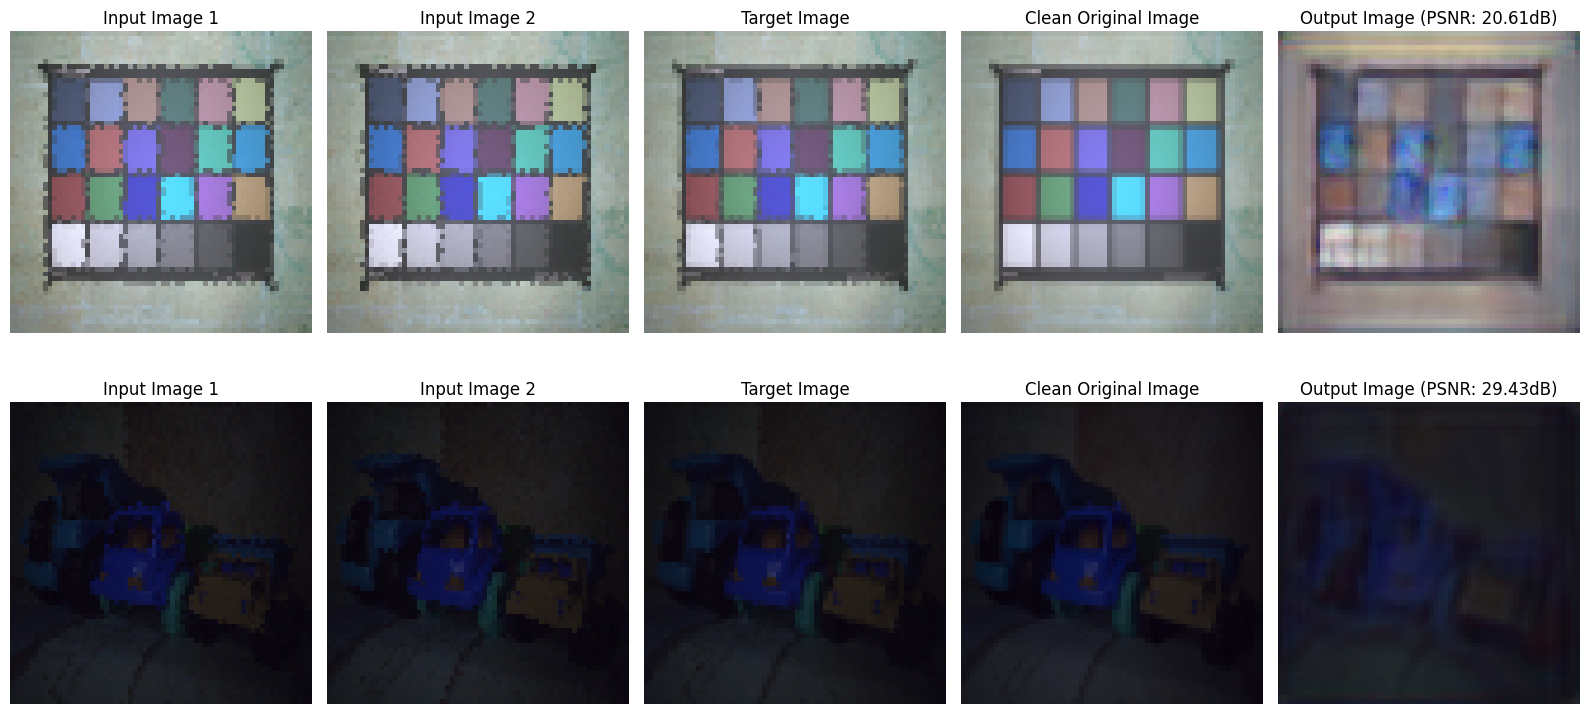

Epoch 76/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.33it/s]


Epoch 76/100 - Train Loss: 0.0048, Val Loss: 0.0038, Val PSNR: 26.03dB


Epoch 77/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.32it/s]


Epoch 77/100 - Train Loss: 0.0082, Val Loss: 0.0056, Val PSNR: 25.25dB


Epoch 78/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 271.67it/s]


Epoch 78/100 - Train Loss: 0.0058, Val Loss: 0.0040, Val PSNR: 25.84dB


Epoch 79/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 318.74it/s]


Epoch 79/100 - Train Loss: 0.0054, Val Loss: 0.0043, Val PSNR: 24.99dB


Epoch 80/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.10it/s]


Epoch 80/100 - Train Loss: 0.0039, Val Loss: 0.0047, Val PSNR: 26.02dB


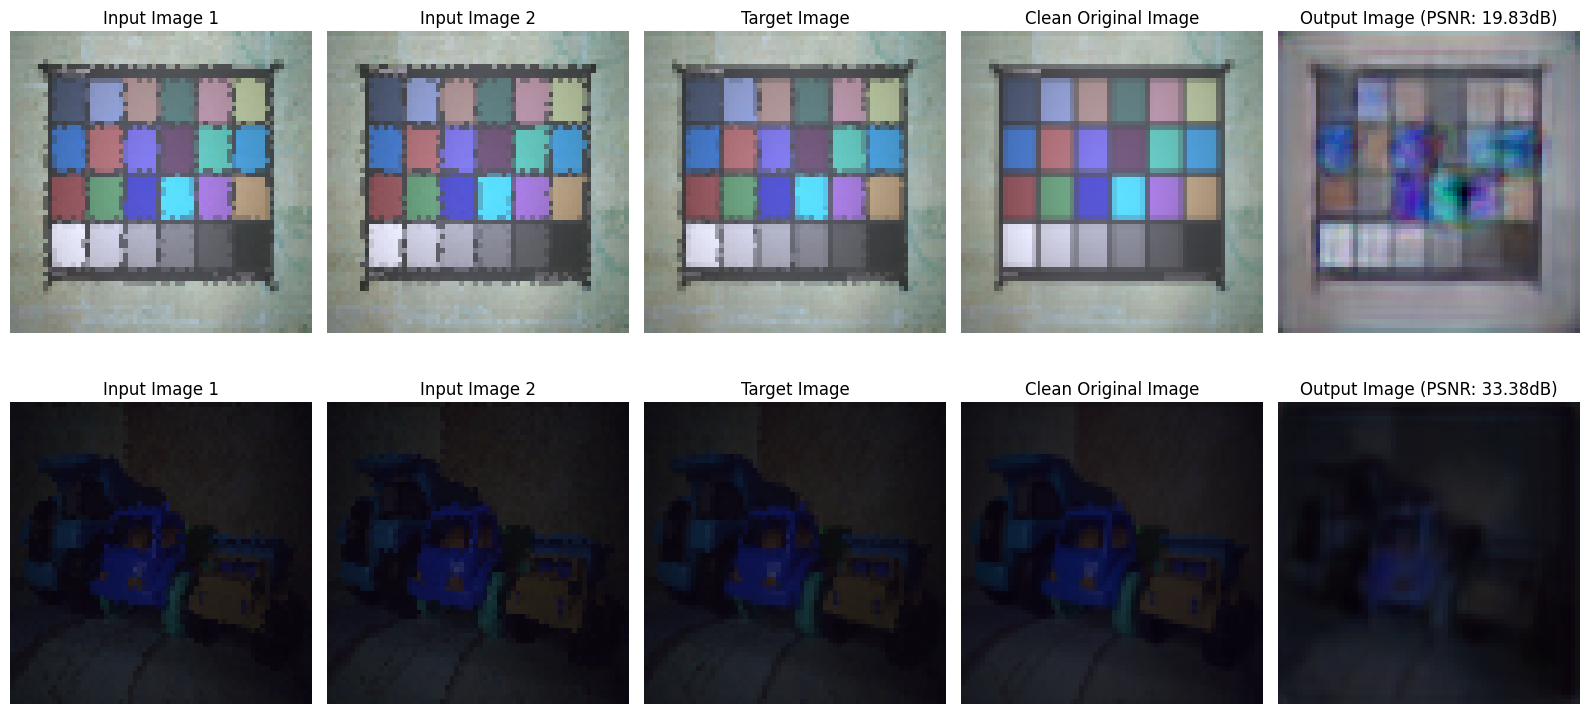

Epoch 81/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 272.92it/s]


Epoch 81/100 - Train Loss: 0.0038, Val Loss: 0.0034, Val PSNR: 26.28dB


Epoch 82/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.31it/s]


Epoch 82/100 - Train Loss: 0.0035, Val Loss: 0.0031, Val PSNR: 26.60dB


Epoch 83/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.28it/s]


Epoch 83/100 - Train Loss: 0.0030, Val Loss: 0.0029, Val PSNR: 27.37dB


Epoch 84/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.93it/s]


Epoch 84/100 - Train Loss: 0.0031, Val Loss: 0.0038, Val PSNR: 26.68dB


Epoch 85/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 285.17it/s]


Epoch 85/100 - Train Loss: 0.0033, Val Loss: 0.0061, Val PSNR: 24.94dB


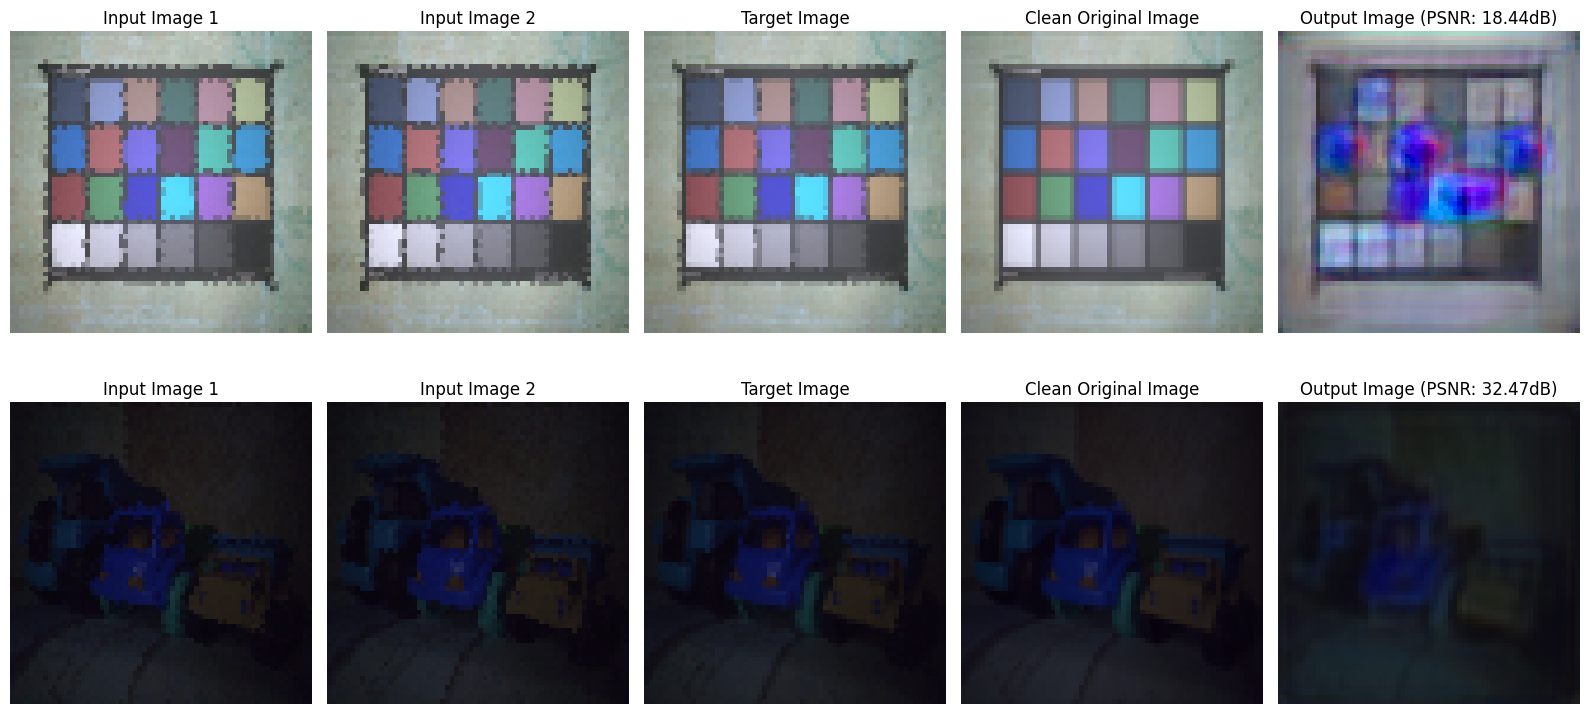

Epoch 86/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 305.58it/s]


Epoch 86/100 - Train Loss: 0.0034, Val Loss: 0.0030, Val PSNR: 27.13dB


Epoch 87/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 332.96it/s]


Epoch 87/100 - Train Loss: 0.0037, Val Loss: 0.0029, Val PSNR: 26.95dB


Epoch 88/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 319.72it/s]


Epoch 88/100 - Train Loss: 0.0031, Val Loss: 0.0029, Val PSNR: 27.44dB


Epoch 89/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 307.70it/s]


Epoch 89/100 - Train Loss: 0.0027, Val Loss: 0.0026, Val PSNR: 27.89dB


Epoch 90/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 320.04it/s]


Epoch 90/100 - Train Loss: 0.0026, Val Loss: 0.0032, Val PSNR: 27.22dB


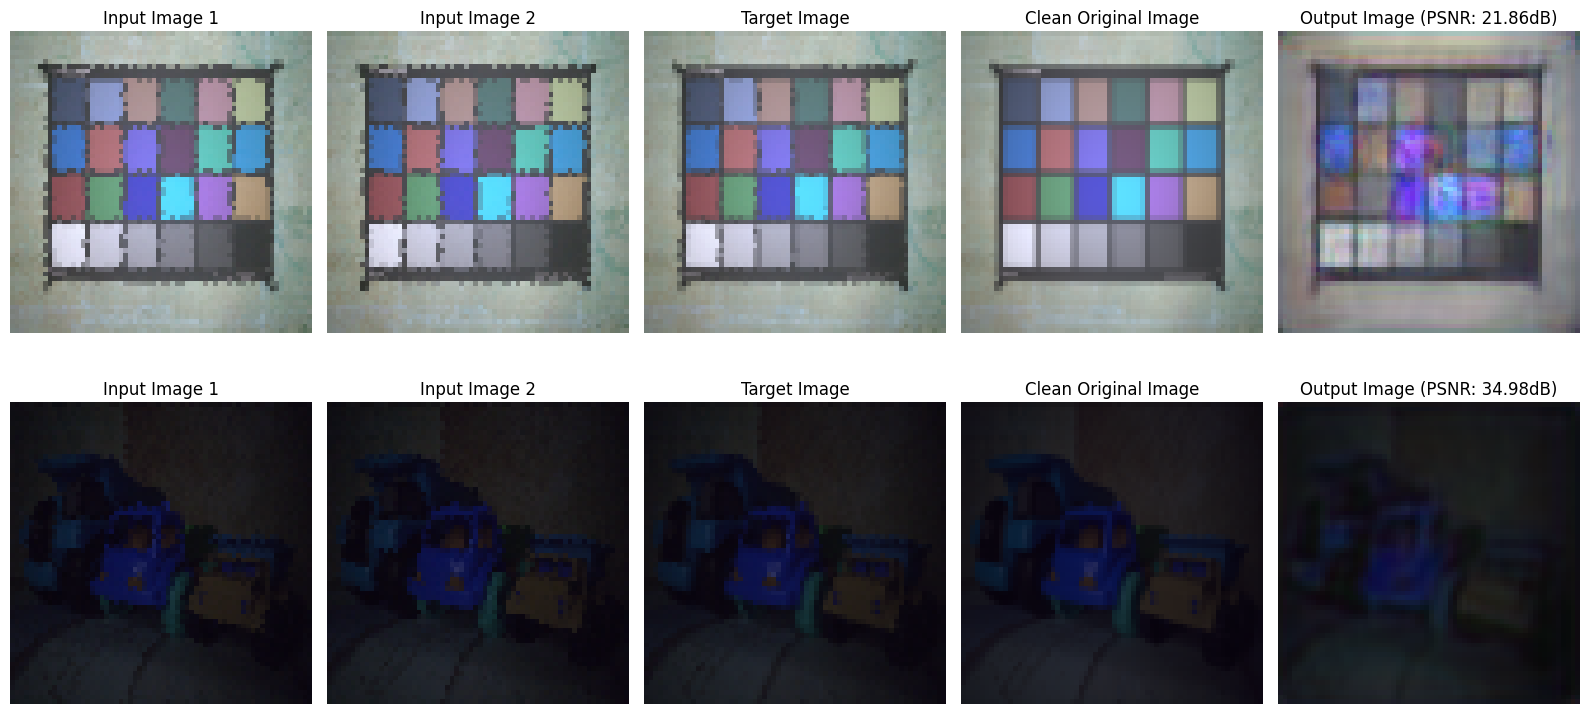

Epoch 91/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 313.58it/s]


Epoch 91/100 - Train Loss: 0.0029, Val Loss: 0.0033, Val PSNR: 27.21dB


Epoch 92/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 340.29it/s]


Epoch 92/100 - Train Loss: 0.0031, Val Loss: 0.0034, Val PSNR: 26.07dB


Epoch 93/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 333.36it/s]


Epoch 93/100 - Train Loss: 0.0031, Val Loss: 0.0026, Val PSNR: 27.79dB


Epoch 94/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 307.69it/s]


Epoch 94/100 - Train Loss: 0.0030, Val Loss: 0.0040, Val PSNR: 26.63dB


Epoch 95/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 296.30it/s]


Epoch 95/100 - Train Loss: 0.0027, Val Loss: 0.0033, Val PSNR: 27.49dB


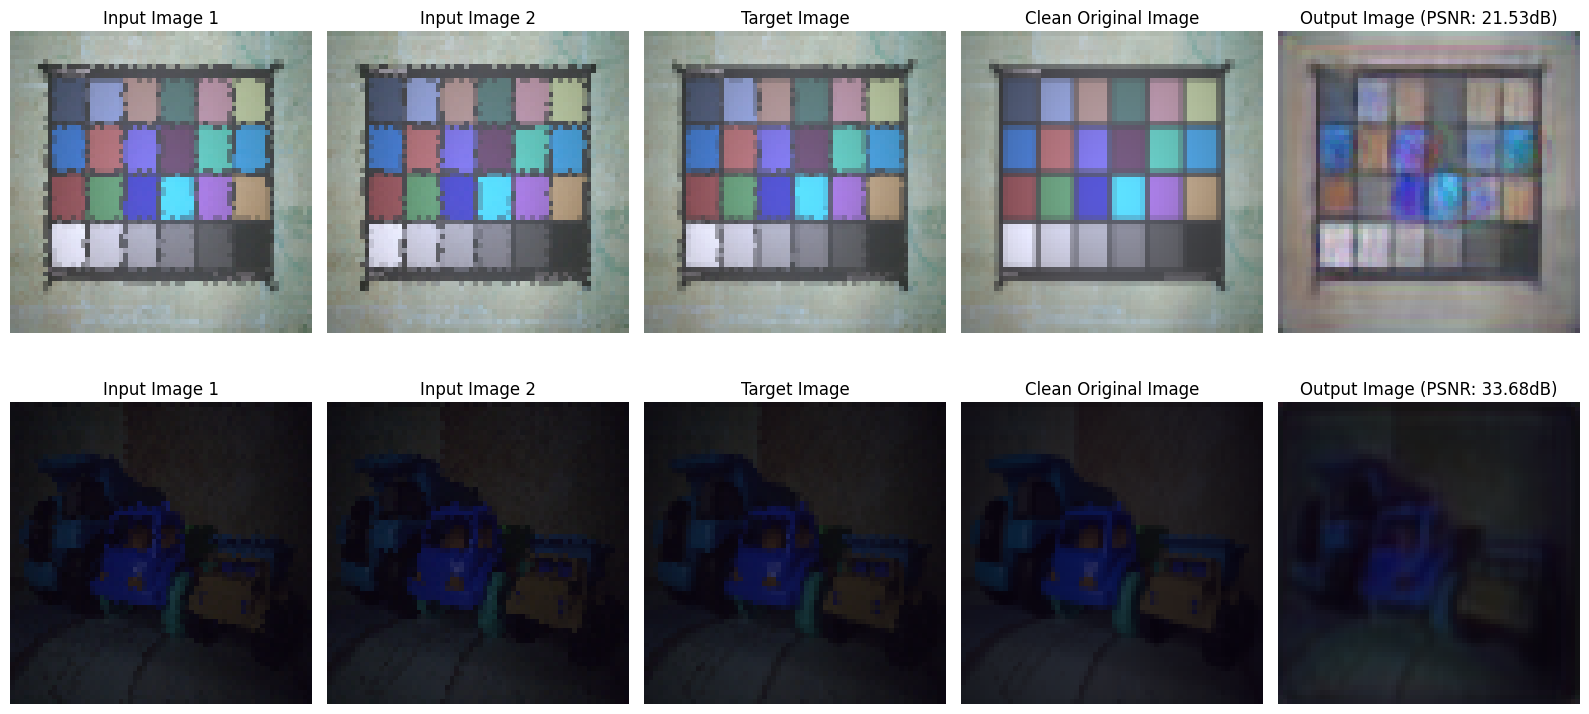

Epoch 96/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 240.62it/s]


Epoch 96/100 - Train Loss: 0.0029, Val Loss: 0.0026, Val PSNR: 27.71dB


Epoch 97/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 307.63it/s]


Epoch 97/100 - Train Loss: 0.0026, Val Loss: 0.0026, Val PSNR: 27.80dB


Epoch 98/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 285.72it/s]


Epoch 98/100 - Train Loss: 0.0026, Val Loss: 0.0027, Val PSNR: 28.22dB


Epoch 99/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 327.35it/s]


Epoch 99/100 - Train Loss: 0.0026, Val Loss: 0.0028, Val PSNR: 27.84dB


Epoch 100/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 307.69it/s]


Epoch 100/100 - Train Loss: 0.0028, Val Loss: 0.0030, Val PSNR: 26.87dB


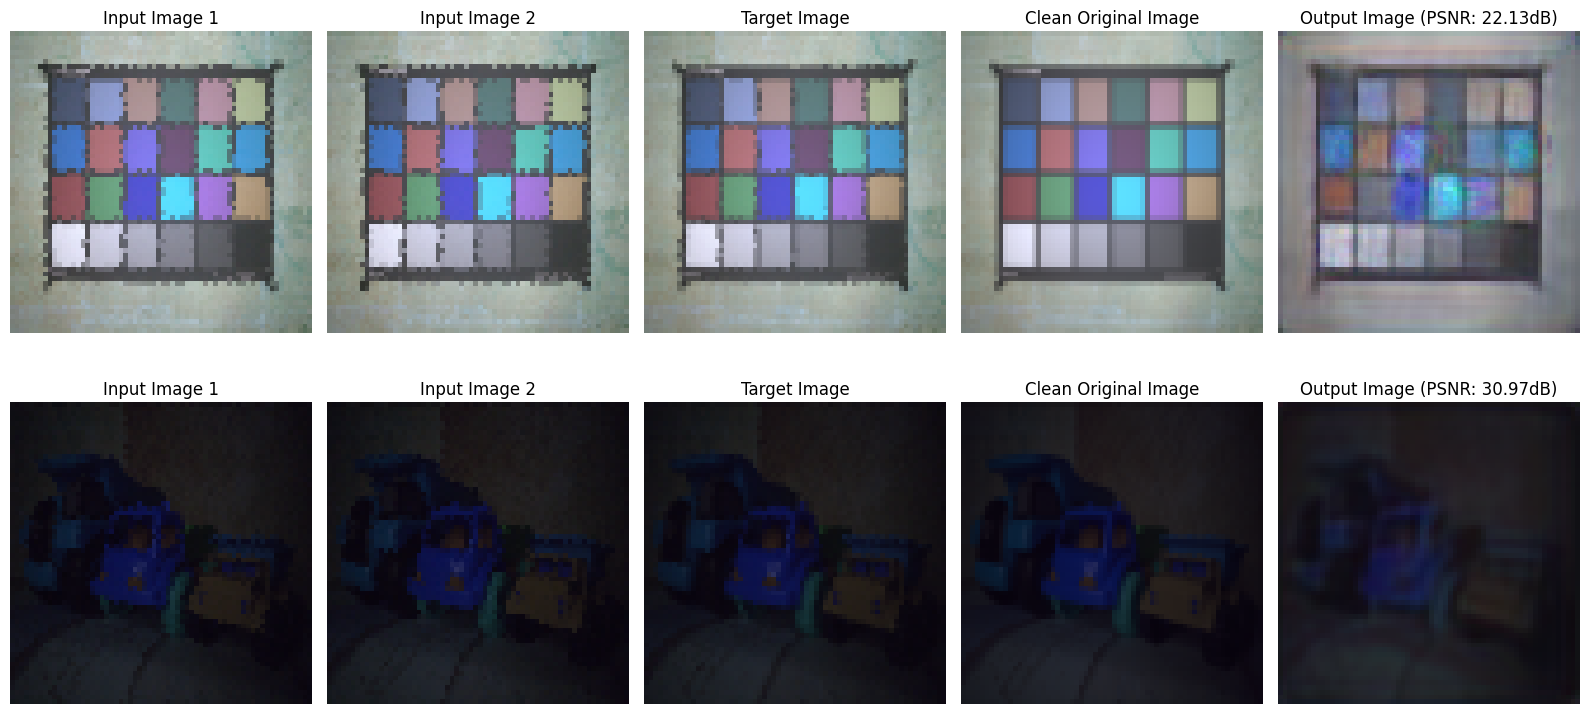

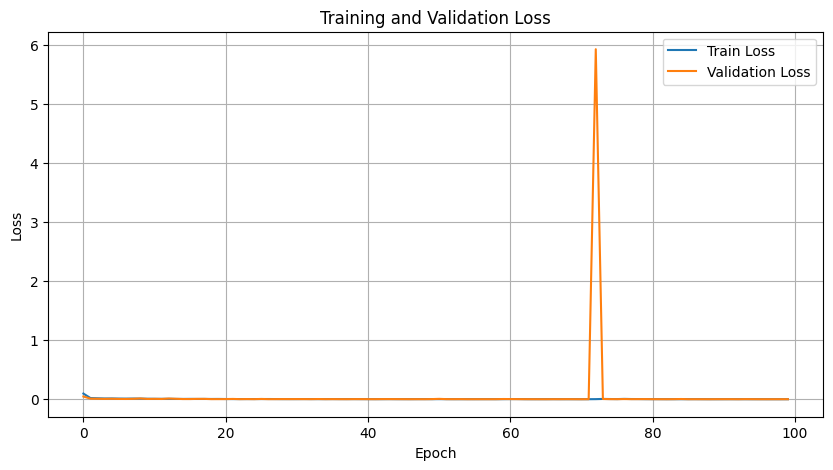

최종 모델 저장 완료: ./checkpoints\final_dncnn_model.pth
최종 결과 시각화 중...


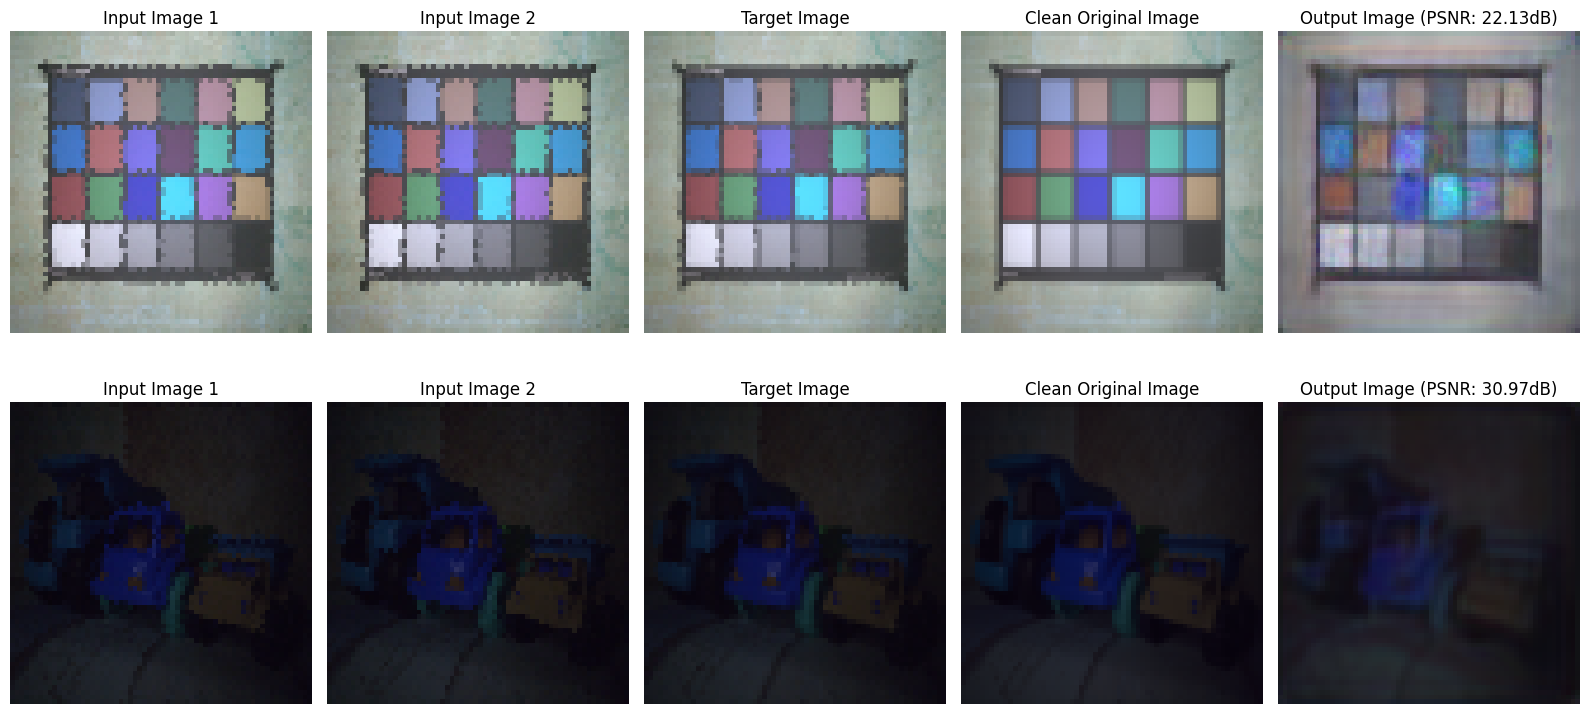

학습 및 평가 완료!


In [8]:

# 실행 코드
if __name__ == "__main__":
    # 하이퍼파라미터 설정
    num_epochs = 100  # 학습 에폭 수
    batch_size = 4   # 배치 크기
    learning_rate = 0.0001  # 학습률
    img_size = 128  # 이미지 크기
    ca = None  # 'ca'로 설정하면 채널 어텐션 모델 사용
    
    # 학습 실행
    model, train_losses, val_losses = main(
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        img_size=img_size,
        ca=ca
    )

In [9]:
import torch

torch.cuda.empty_cache()
print("GPU memory cleared.")

GPU memory cleared.


사용 중인 디바이스: cuda
SIDD 데이터셋 로드 중...


C:\Users\pook0\AppData\Local\Temp\ipykernel_18708\2525196961.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(cache_file)


데이터 로드 완료: noisy shape (160, 1024, 1024, 3), gt shape (160, 1024, 1024, 3)
=== SIDD_Dataset 초기화 (img_size=128) ===
캐시 파일을 로드합니다: ./dataset_cache\sidd_processed_128.pt
캐시 로드 완료. 소요 시간: 0.01초
데이터 크기: 160 샘플, 이미지 크기: 64x64
학습 샘플 수: 128, 검증 샘플 수: 32
모델 초기화 중...
채널 어텐션이 포함된 DnCNN 모델 생성됨
모델 총 파라미터: 493,475
학습 시작 - 100 에폭


Epoch 1/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 89.61it/s]


Epoch 1/100 - Train Loss: 0.0786, Val Loss: 0.0467, Val PSNR: 16.47dB
모델 저장됨 (Val Loss: 0.0467)


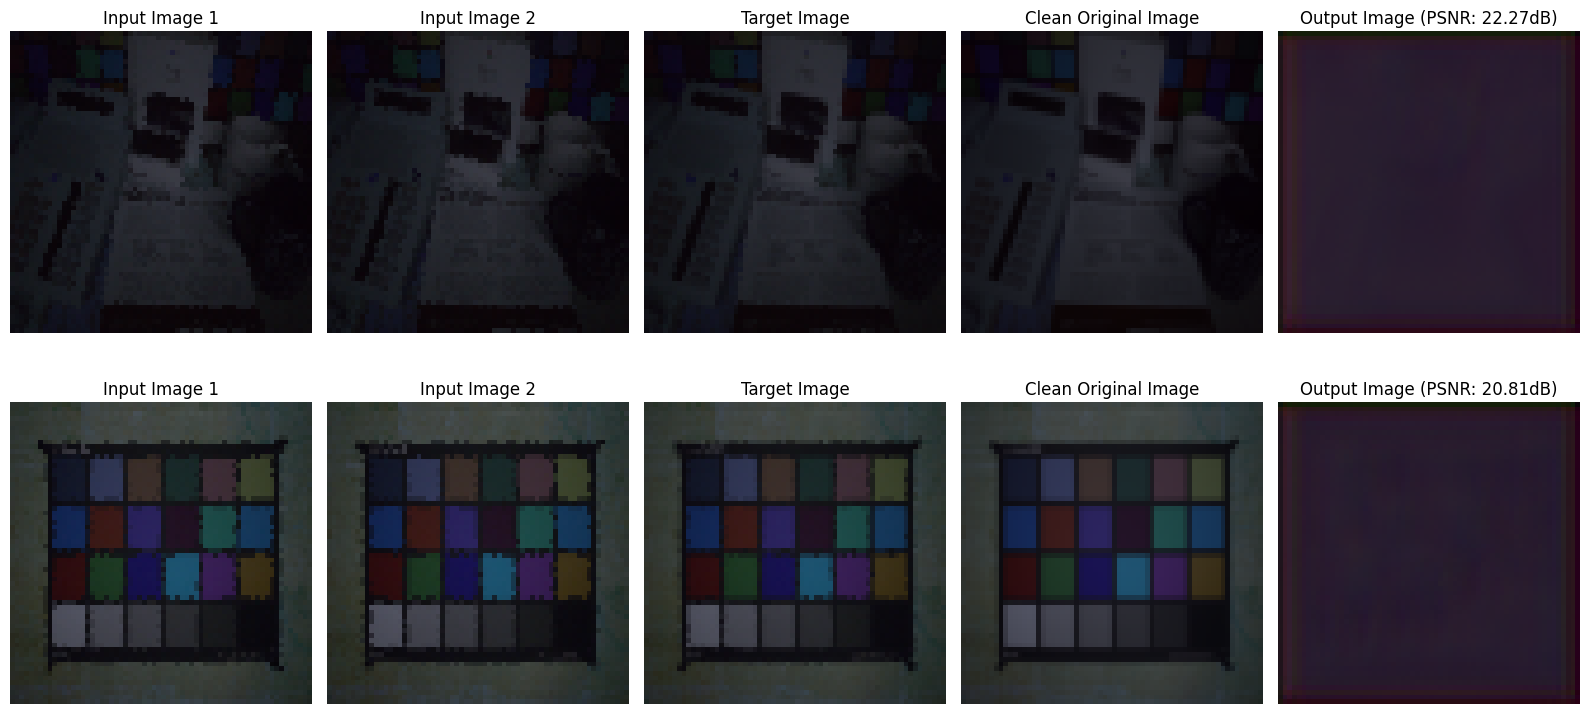

Epoch 2/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.38it/s]


Epoch 2/100 - Train Loss: 0.0152, Val Loss: 0.0121, Val PSNR: 20.29dB
모델 저장됨 (Val Loss: 0.0121)


Epoch 3/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 89.88it/s]


Epoch 3/100 - Train Loss: 0.0152, Val Loss: 0.0090, Val PSNR: 21.20dB
모델 저장됨 (Val Loss: 0.0090)


Epoch 4/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.39it/s]


Epoch 4/100 - Train Loss: 0.0126, Val Loss: 0.0067, Val PSNR: 23.23dB
모델 저장됨 (Val Loss: 0.0067)


Epoch 5/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.48it/s]


Epoch 5/100 - Train Loss: 0.0112, Val Loss: 0.0052, Val PSNR: 24.12dB
모델 저장됨 (Val Loss: 0.0052)


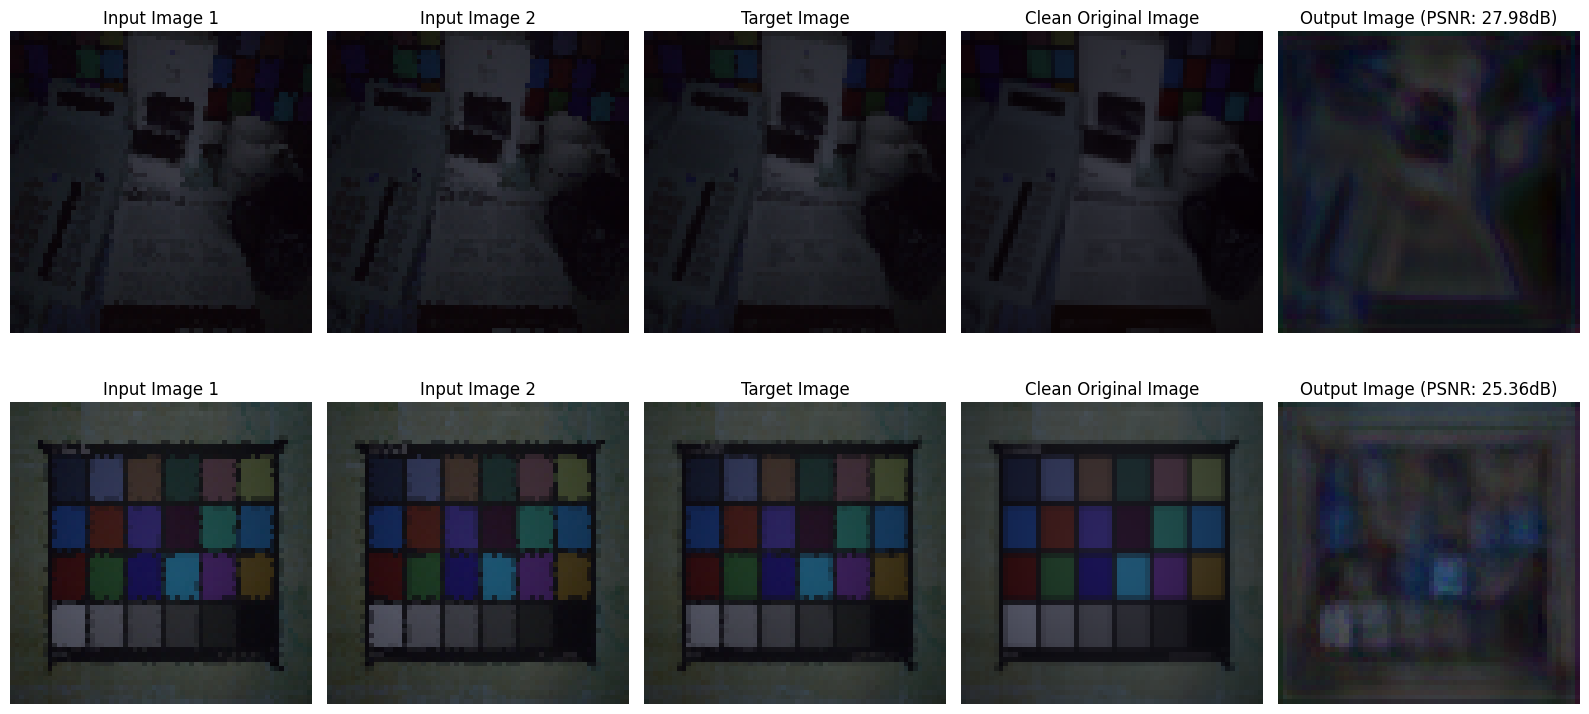

Epoch 6/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 89.37it/s]


Epoch 6/100 - Train Loss: 0.0094, Val Loss: 0.0051, Val PSNR: 24.05dB
모델 저장됨 (Val Loss: 0.0051)


Epoch 7/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.41it/s]


Epoch 7/100 - Train Loss: 0.0088, Val Loss: 0.0093, Val PSNR: 22.65dB


Epoch 8/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 8/100 - Train Loss: 0.0087, Val Loss: 0.0075, Val PSNR: 22.06dB


Epoch 9/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 9/100 - Train Loss: 0.0088, Val Loss: 0.0256, Val PSNR: 18.08dB


Epoch 10/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 10/100 - Train Loss: 0.0122, Val Loss: 0.0058, Val PSNR: 24.34dB


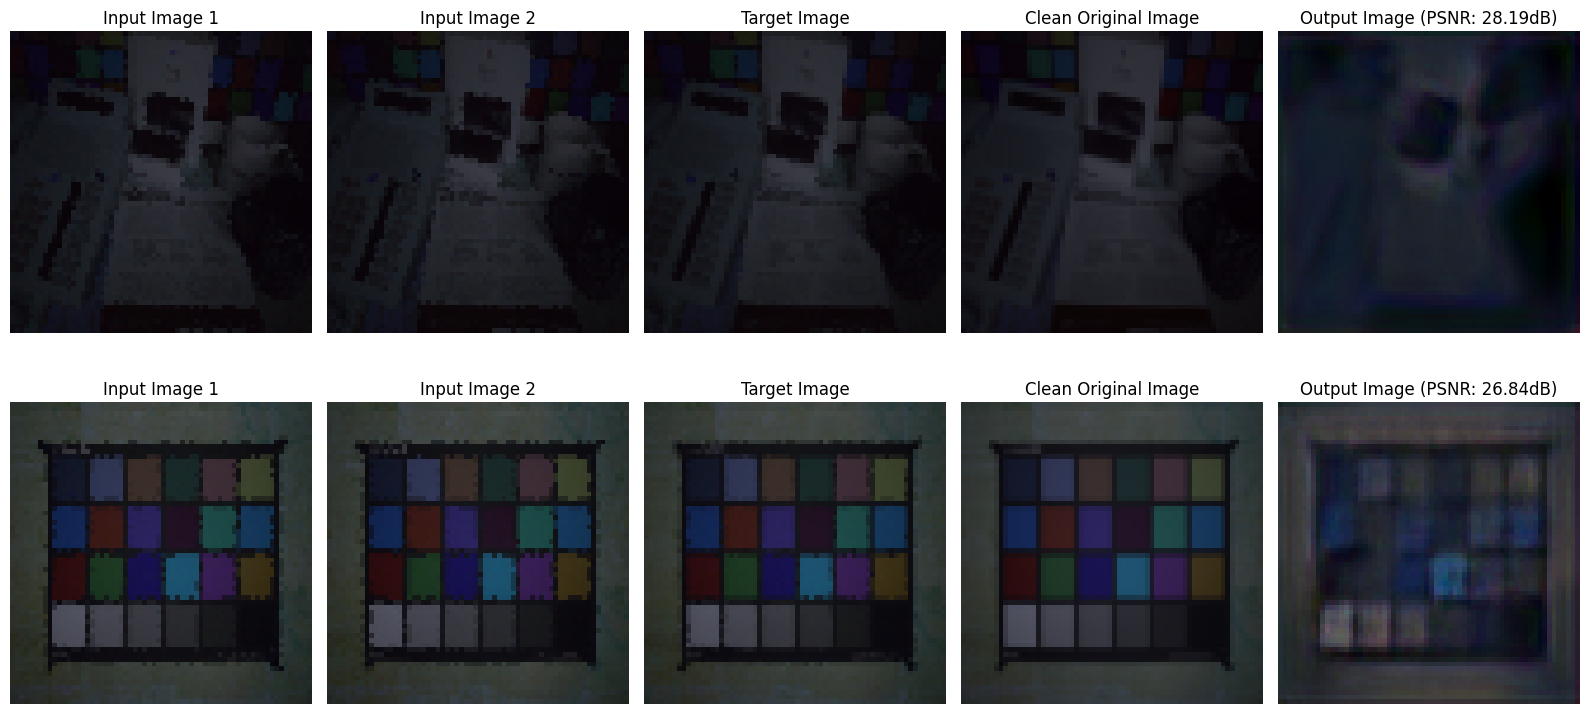

Epoch 11/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.75it/s]


Epoch 11/100 - Train Loss: 0.0065, Val Loss: 0.0056, Val PSNR: 24.12dB


Epoch 12/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 12/100 - Train Loss: 0.0075, Val Loss: 0.0059, Val PSNR: 23.18dB


Epoch 13/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 13/100 - Train Loss: 0.0071, Val Loss: 0.0043, Val PSNR: 24.50dB
모델 저장됨 (Val Loss: 0.0043)


Epoch 14/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.55it/s]


Epoch 14/100 - Train Loss: 0.0068, Val Loss: 0.0050, Val PSNR: 25.02dB


Epoch 15/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.38it/s]


Epoch 15/100 - Train Loss: 0.0059, Val Loss: 0.0055, Val PSNR: 23.83dB


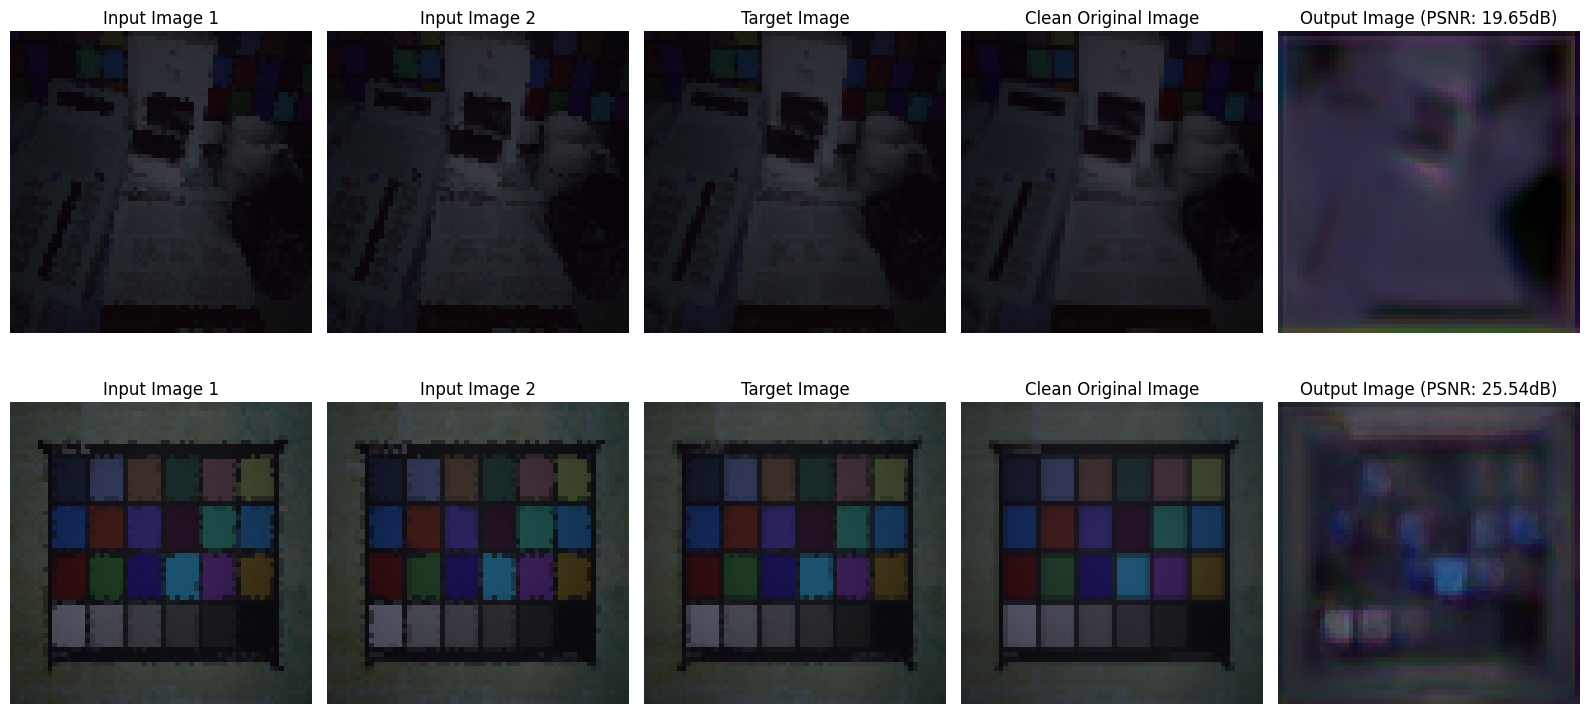

Epoch 16/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.95it/s]


Epoch 16/100 - Train Loss: 0.0052, Val Loss: 0.0087, Val PSNR: 23.59dB


Epoch 17/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 17/100 - Train Loss: 0.0067, Val Loss: 0.0068, Val PSNR: 22.89dB


Epoch 18/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.02it/s]


Epoch 18/100 - Train Loss: 0.0060, Val Loss: 0.0048, Val PSNR: 24.96dB


Epoch 19/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.56it/s]


Epoch 19/100 - Train Loss: 0.0056, Val Loss: 0.0074, Val PSNR: 22.89dB


Epoch 20/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 94.11it/s]


Epoch 20/100 - Train Loss: 0.0049, Val Loss: 0.0046, Val PSNR: 24.70dB


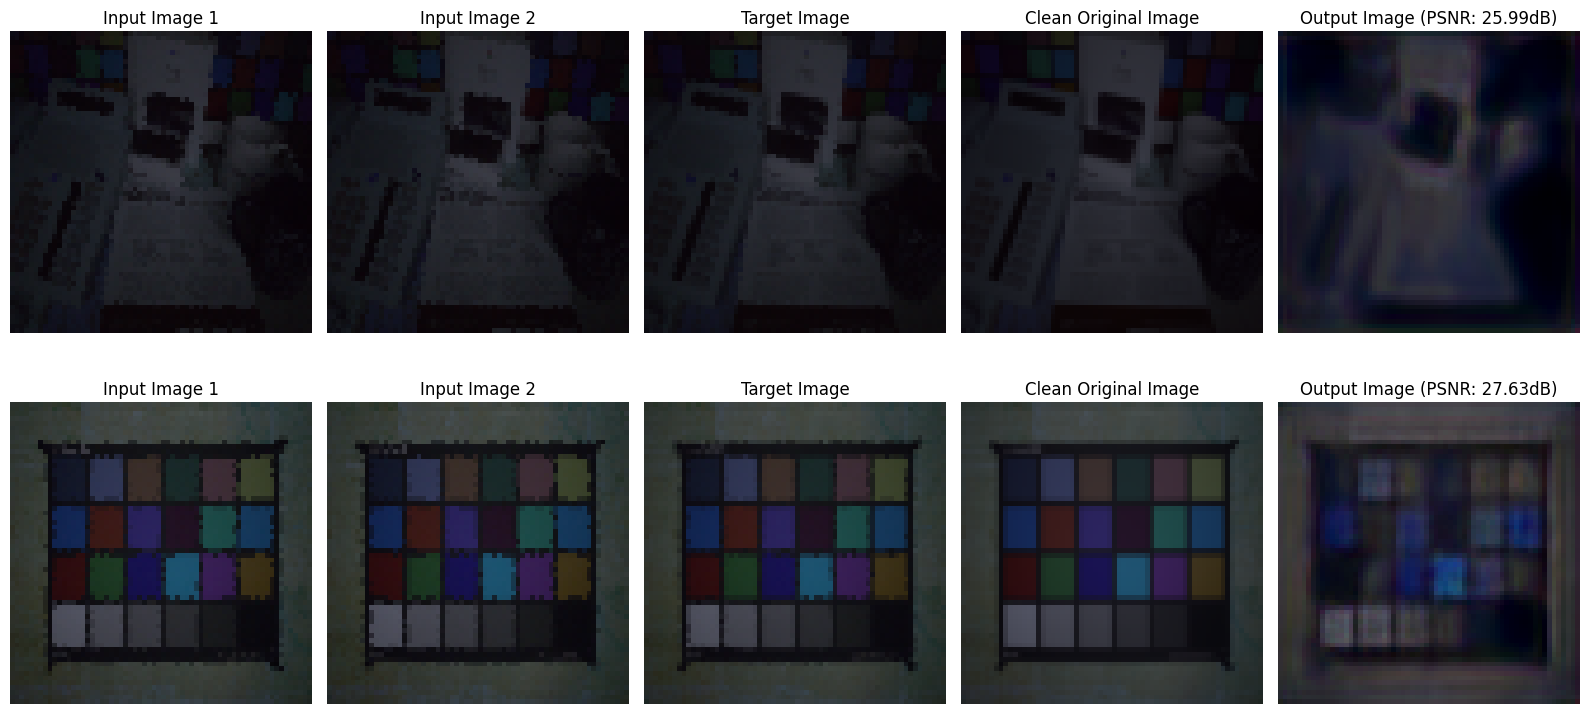

Epoch 21/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 85.55it/s]


Epoch 21/100 - Train Loss: 0.0057, Val Loss: 0.0049, Val PSNR: 24.55dB


Epoch 22/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.18it/s]


Epoch 22/100 - Train Loss: 0.0051, Val Loss: 0.0036, Val PSNR: 26.01dB
모델 저장됨 (Val Loss: 0.0036)


Epoch 23/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.48it/s]


Epoch 23/100 - Train Loss: 0.0046, Val Loss: 0.0034, Val PSNR: 26.04dB
모델 저장됨 (Val Loss: 0.0034)


Epoch 24/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.91it/s]


Epoch 24/100 - Train Loss: 0.0040, Val Loss: 0.0038, Val PSNR: 25.16dB


Epoch 25/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 89.37it/s]


Epoch 25/100 - Train Loss: 0.0038, Val Loss: 0.0035, Val PSNR: 26.03dB


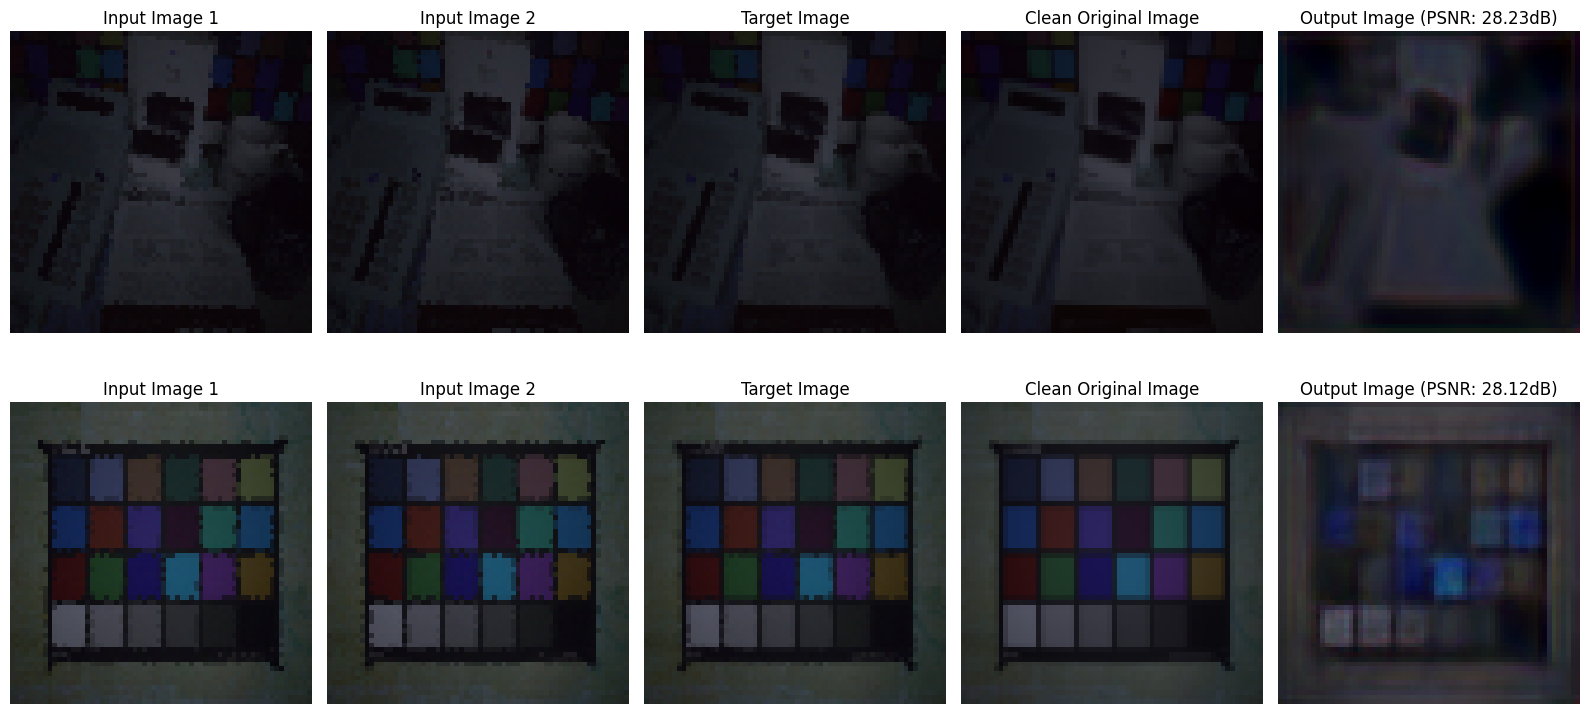

Epoch 26/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 89.37it/s]


Epoch 26/100 - Train Loss: 0.0047, Val Loss: 0.0057, Val PSNR: 24.72dB


Epoch 27/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 27/100 - Train Loss: 0.0043, Val Loss: 0.0031, Val PSNR: 26.14dB
모델 저장됨 (Val Loss: 0.0031)


Epoch 28/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.43it/s]


Epoch 28/100 - Train Loss: 0.0037, Val Loss: 0.0031, Val PSNR: 26.35dB
모델 저장됨 (Val Loss: 0.0031)


Epoch 29/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 89.38it/s]


Epoch 29/100 - Train Loss: 0.0034, Val Loss: 0.0035, Val PSNR: 26.76dB


Epoch 30/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.38it/s]


Epoch 30/100 - Train Loss: 0.0032, Val Loss: 0.0030, Val PSNR: 26.57dB
모델 저장됨 (Val Loss: 0.0030)


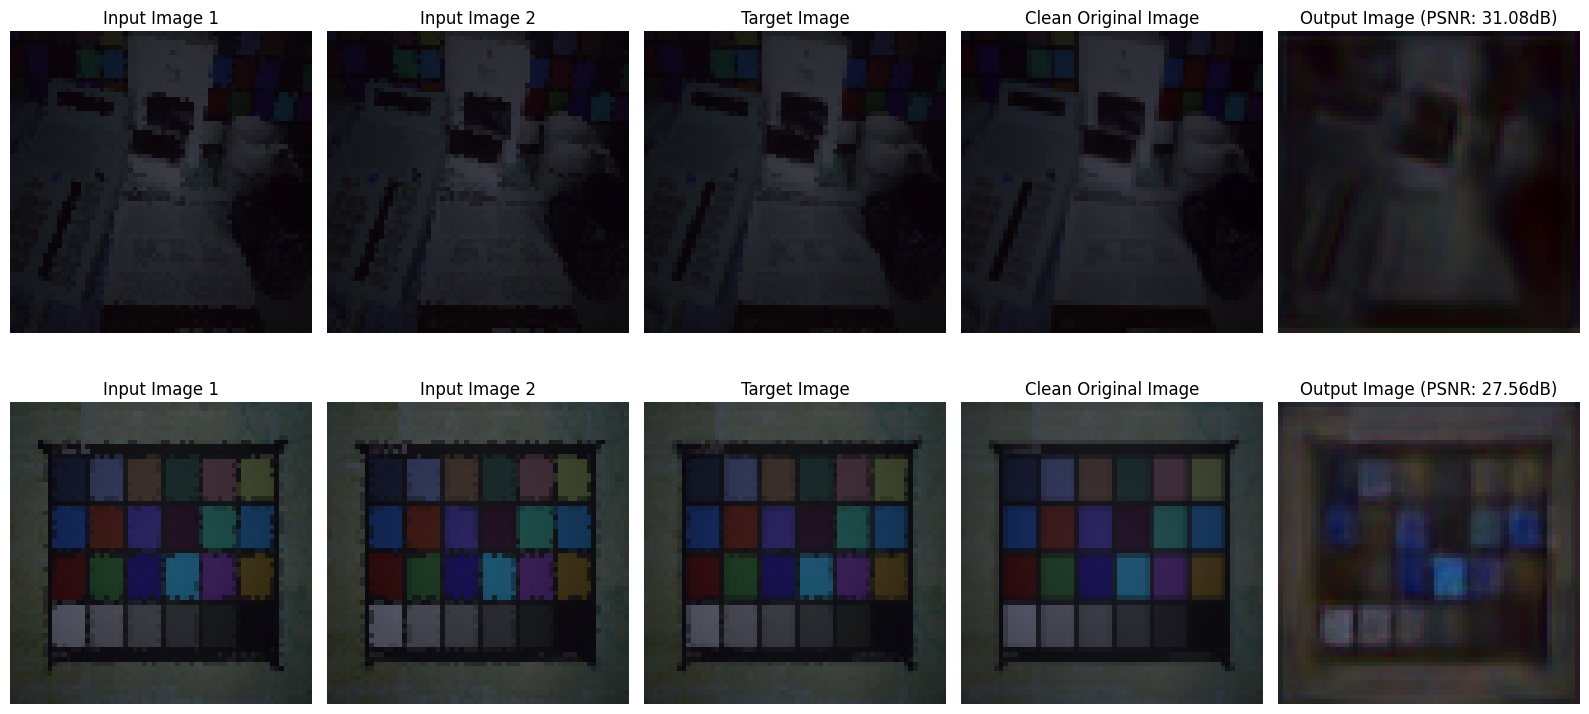

Epoch 31/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.48it/s]


Epoch 31/100 - Train Loss: 0.0036, Val Loss: 0.0034, Val PSNR: 25.86dB


Epoch 32/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 86.48it/s]


Epoch 32/100 - Train Loss: 0.0048, Val Loss: 0.0049, Val PSNR: 24.63dB


Epoch 33/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 33/100 - Train Loss: 0.0063, Val Loss: 0.0044, Val PSNR: 24.89dB


Epoch 34/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.41it/s]


Epoch 34/100 - Train Loss: 0.0056, Val Loss: 0.0045, Val PSNR: 24.82dB


Epoch 35/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.85it/s]


Epoch 35/100 - Train Loss: 0.0044, Val Loss: 0.0038, Val PSNR: 25.07dB


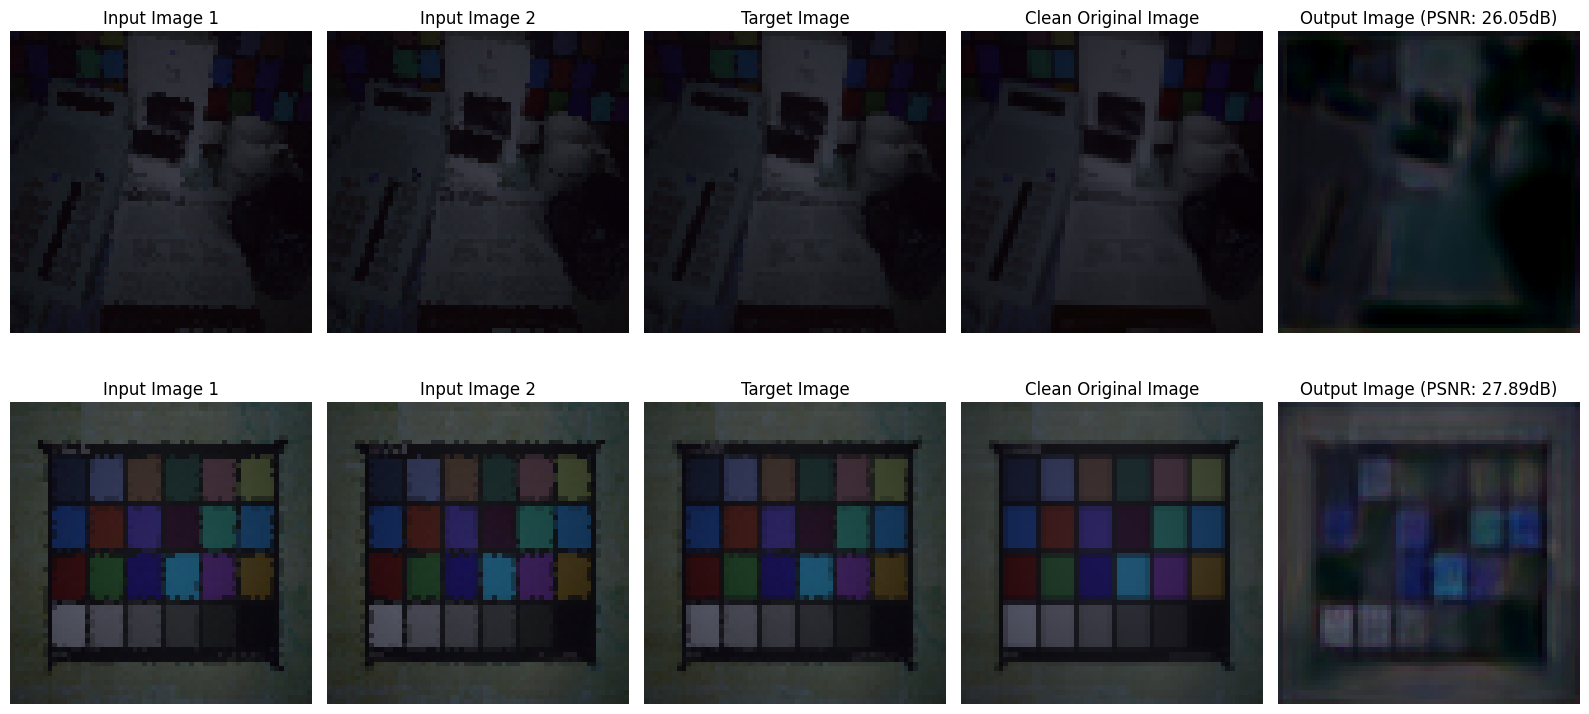

Epoch 36/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 36/100 - Train Loss: 0.0039, Val Loss: 0.0026, Val PSNR: 27.12dB
모델 저장됨 (Val Loss: 0.0026)


Epoch 37/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.12it/s]


Epoch 37/100 - Train Loss: 0.0046, Val Loss: 0.0026, Val PSNR: 26.92dB
모델 저장됨 (Val Loss: 0.0026)


Epoch 38/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 38/100 - Train Loss: 0.0039, Val Loss: 0.0038, Val PSNR: 26.20dB


Epoch 39/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.47it/s]


Epoch 39/100 - Train Loss: 0.0038, Val Loss: 0.0027, Val PSNR: 26.97dB


Epoch 40/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.06it/s]


Epoch 40/100 - Train Loss: 0.0039, Val Loss: 0.0030, Val PSNR: 26.16dB


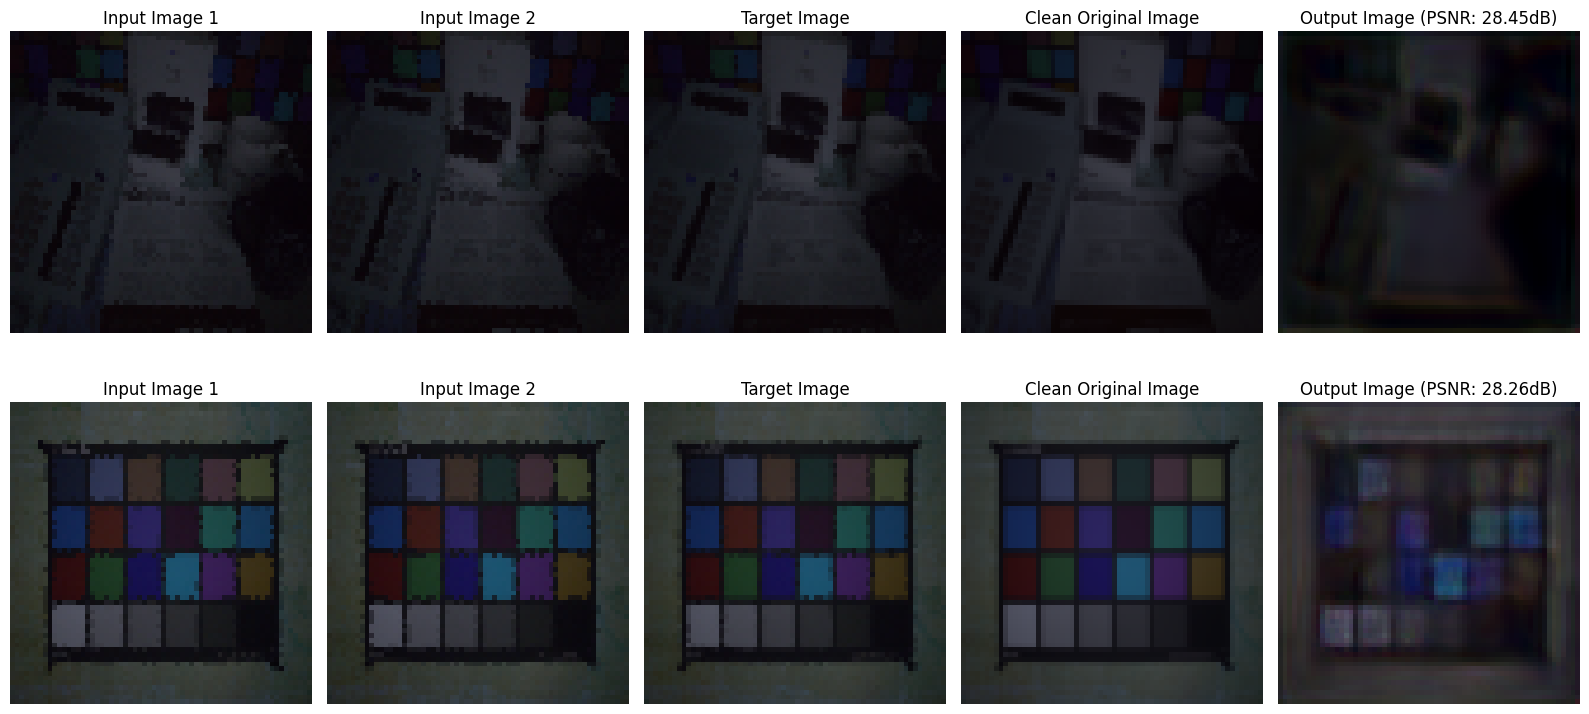

Epoch 41/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 85.55it/s]


Epoch 41/100 - Train Loss: 0.0027, Val Loss: 0.0023, Val PSNR: 27.74dB
모델 저장됨 (Val Loss: 0.0023)


Epoch 42/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.38it/s]


Epoch 42/100 - Train Loss: 0.0032, Val Loss: 0.0031, Val PSNR: 26.31dB


Epoch 43/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 43/100 - Train Loss: 0.0044, Val Loss: 0.0039, Val PSNR: 25.55dB


Epoch 44/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.52it/s]


Epoch 44/100 - Train Loss: 0.0042, Val Loss: 0.0030, Val PSNR: 26.08dB


Epoch 45/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.55it/s]


Epoch 45/100 - Train Loss: 0.0036, Val Loss: 0.0024, Val PSNR: 27.77dB


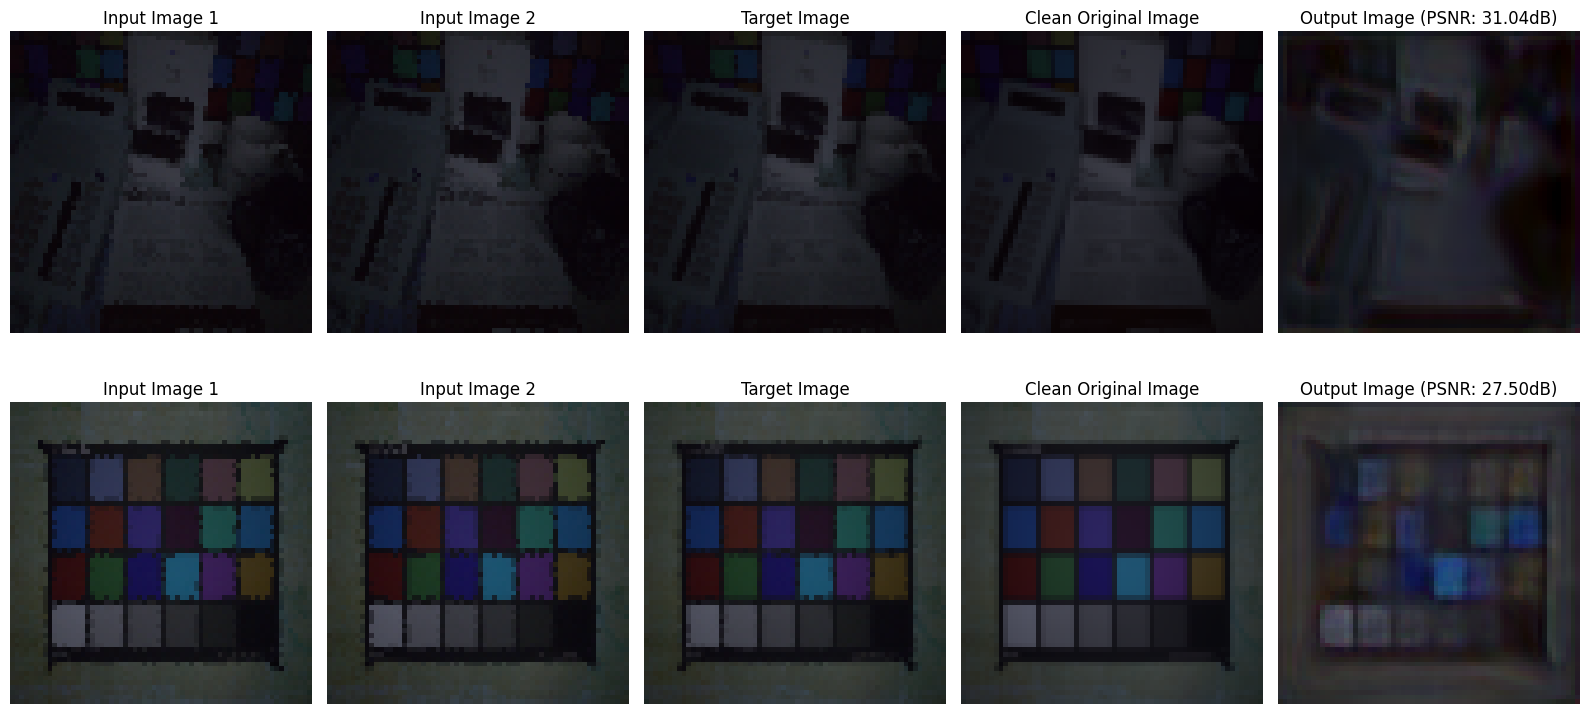

Epoch 46/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 46/100 - Train Loss: 0.0057, Val Loss: 0.0028, Val PSNR: 27.00dB


Epoch 47/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 86.48it/s]


Epoch 47/100 - Train Loss: 0.0030, Val Loss: 0.0021, Val PSNR: 28.45dB
모델 저장됨 (Val Loss: 0.0021)


Epoch 48/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.47it/s]


Epoch 48/100 - Train Loss: 0.0035, Val Loss: 0.0034, Val PSNR: 26.66dB


Epoch 49/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 87.42it/s]


Epoch 49/100 - Train Loss: 0.0032, Val Loss: 0.0032, Val PSNR: 25.83dB


Epoch 50/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 50/100 - Train Loss: 0.0028, Val Loss: 0.0040, Val PSNR: 25.49dB


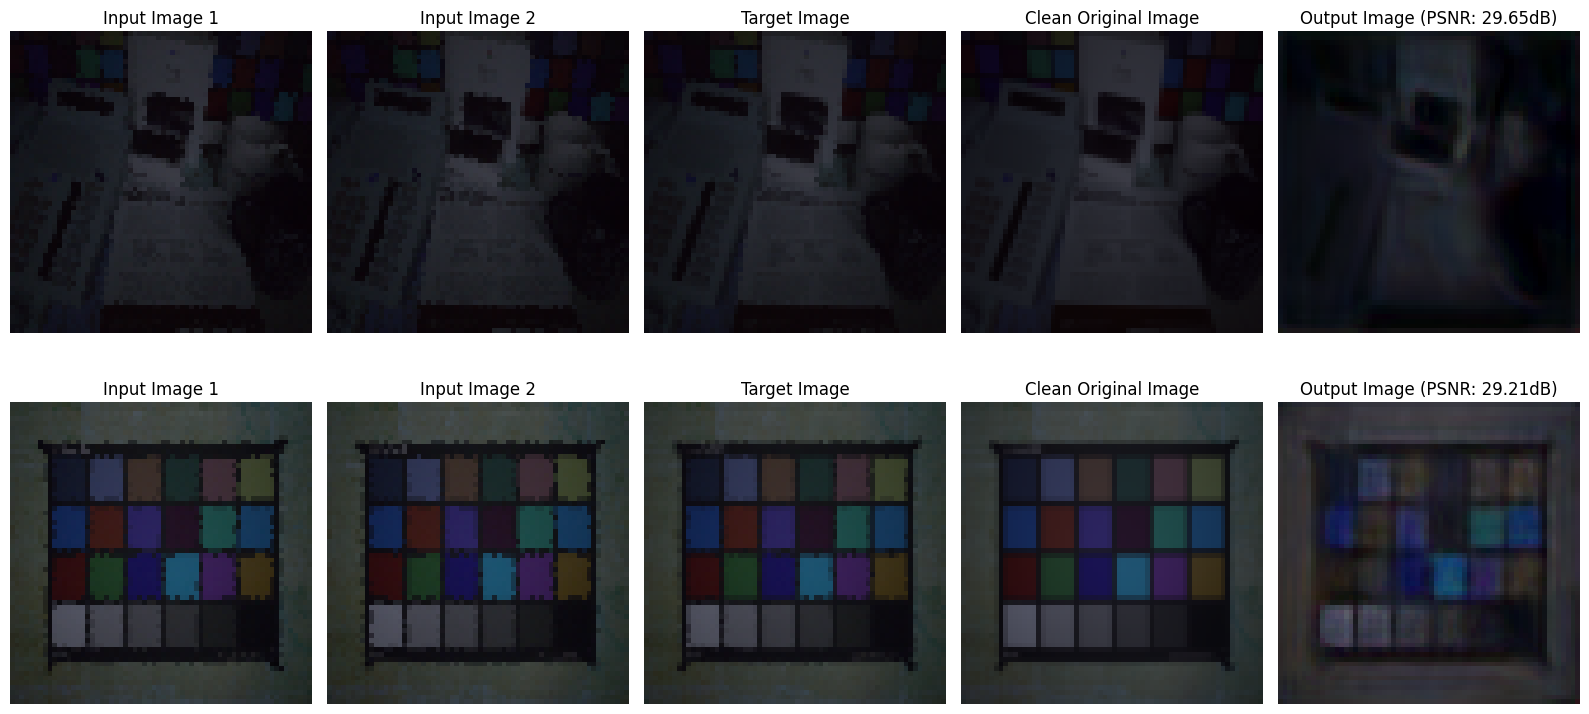

Epoch 51/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 89.42it/s]


Epoch 51/100 - Train Loss: 0.0032, Val Loss: 0.0021, Val PSNR: 28.69dB
모델 저장됨 (Val Loss: 0.0021)


Epoch 52/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.38it/s]


Epoch 52/100 - Train Loss: 0.0042, Val Loss: 0.0023, Val PSNR: 27.88dB


Epoch 53/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.88it/s]


Epoch 53/100 - Train Loss: 0.0028, Val Loss: 0.0024, Val PSNR: 27.81dB


Epoch 54/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.55it/s]


Epoch 54/100 - Train Loss: 0.0041, Val Loss: 0.0029, Val PSNR: 27.09dB


Epoch 55/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.02it/s]


Epoch 55/100 - Train Loss: 0.0040, Val Loss: 0.0025, Val PSNR: 27.94dB


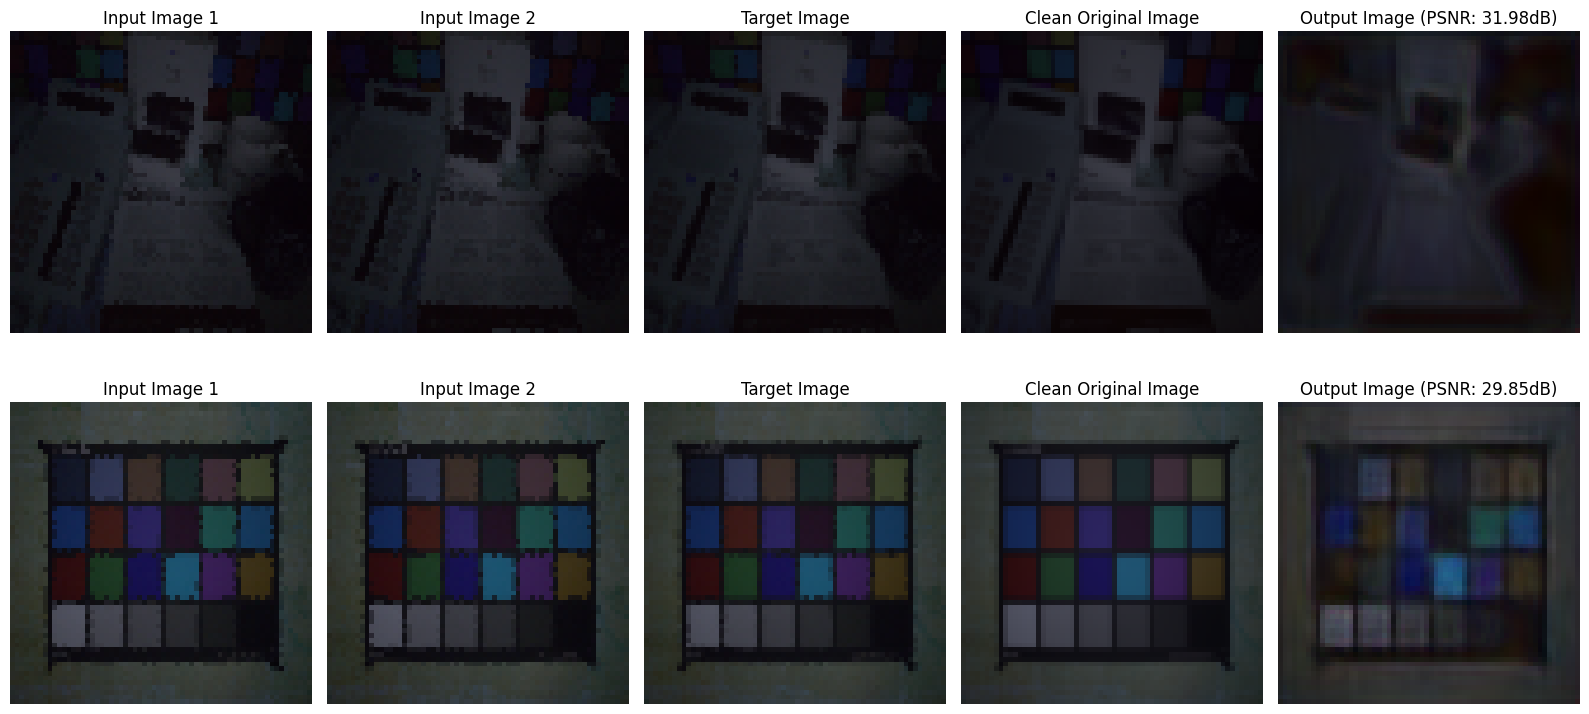

Epoch 56/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 87.42it/s]


Epoch 56/100 - Train Loss: 0.0031, Val Loss: 0.0030, Val PSNR: 27.44dB


Epoch 57/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.38it/s]


Epoch 57/100 - Train Loss: 0.0027, Val Loss: 0.0024, Val PSNR: 28.07dB


Epoch 58/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 58/100 - Train Loss: 0.0040, Val Loss: 0.0027, Val PSNR: 27.16dB


Epoch 59/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.39it/s]


Epoch 59/100 - Train Loss: 0.0034, Val Loss: 0.0023, Val PSNR: 28.04dB


Epoch 60/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.52it/s]


Epoch 60/100 - Train Loss: 0.0026, Val Loss: 0.0022, Val PSNR: 28.11dB


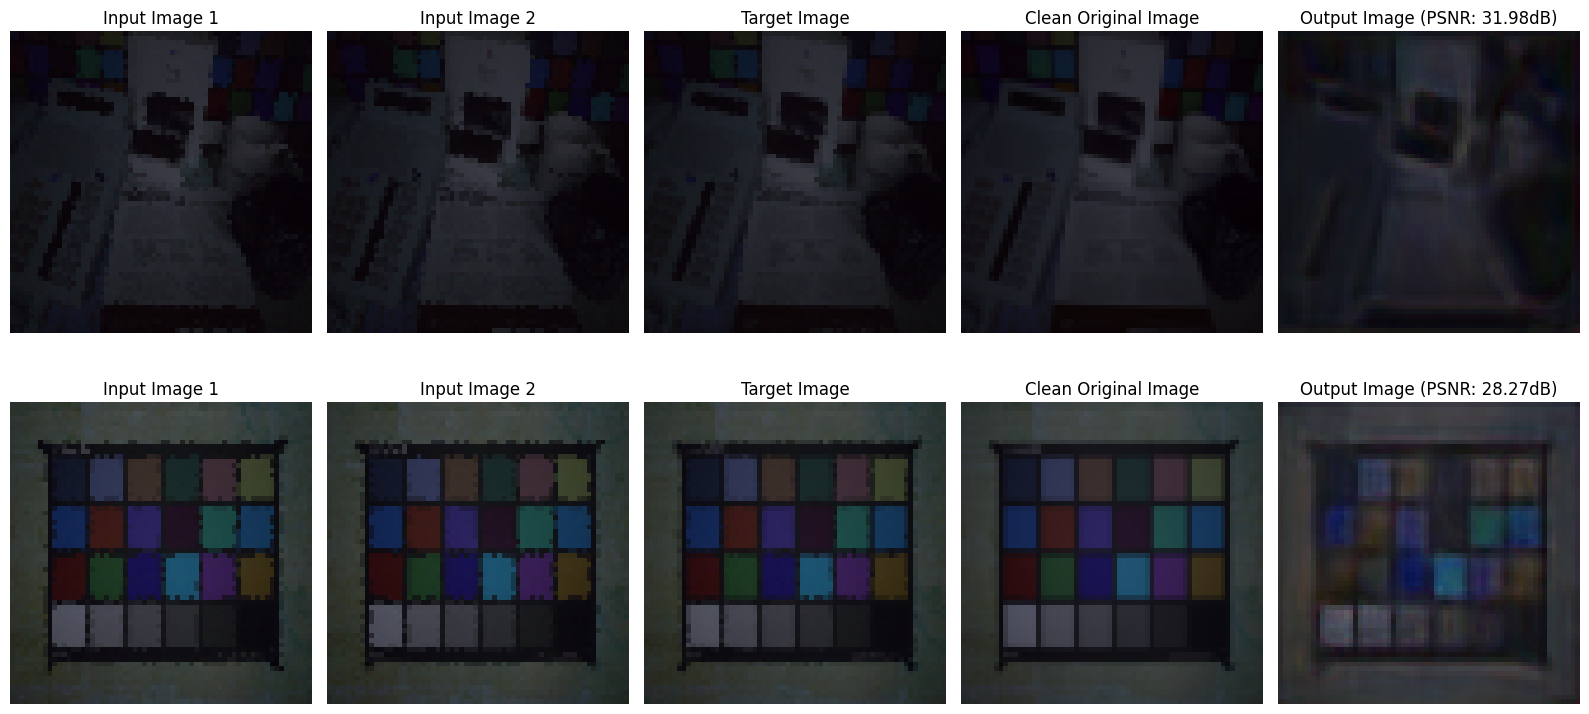

Epoch 61/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 86.48it/s]


Epoch 61/100 - Train Loss: 0.0029, Val Loss: 0.0025, Val PSNR: 27.72dB


Epoch 62/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 62/100 - Train Loss: 0.0029, Val Loss: 0.0031, Val PSNR: 26.98dB


Epoch 63/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.56it/s]


Epoch 63/100 - Train Loss: 0.0027, Val Loss: 0.0034, Val PSNR: 26.51dB


Epoch 64/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 78.41it/s]


Epoch 64/100 - Train Loss: 0.0028, Val Loss: 0.0035, Val PSNR: 25.53dB


Epoch 65/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 65/100 - Train Loss: 0.0028, Val Loss: 0.0026, Val PSNR: 27.52dB


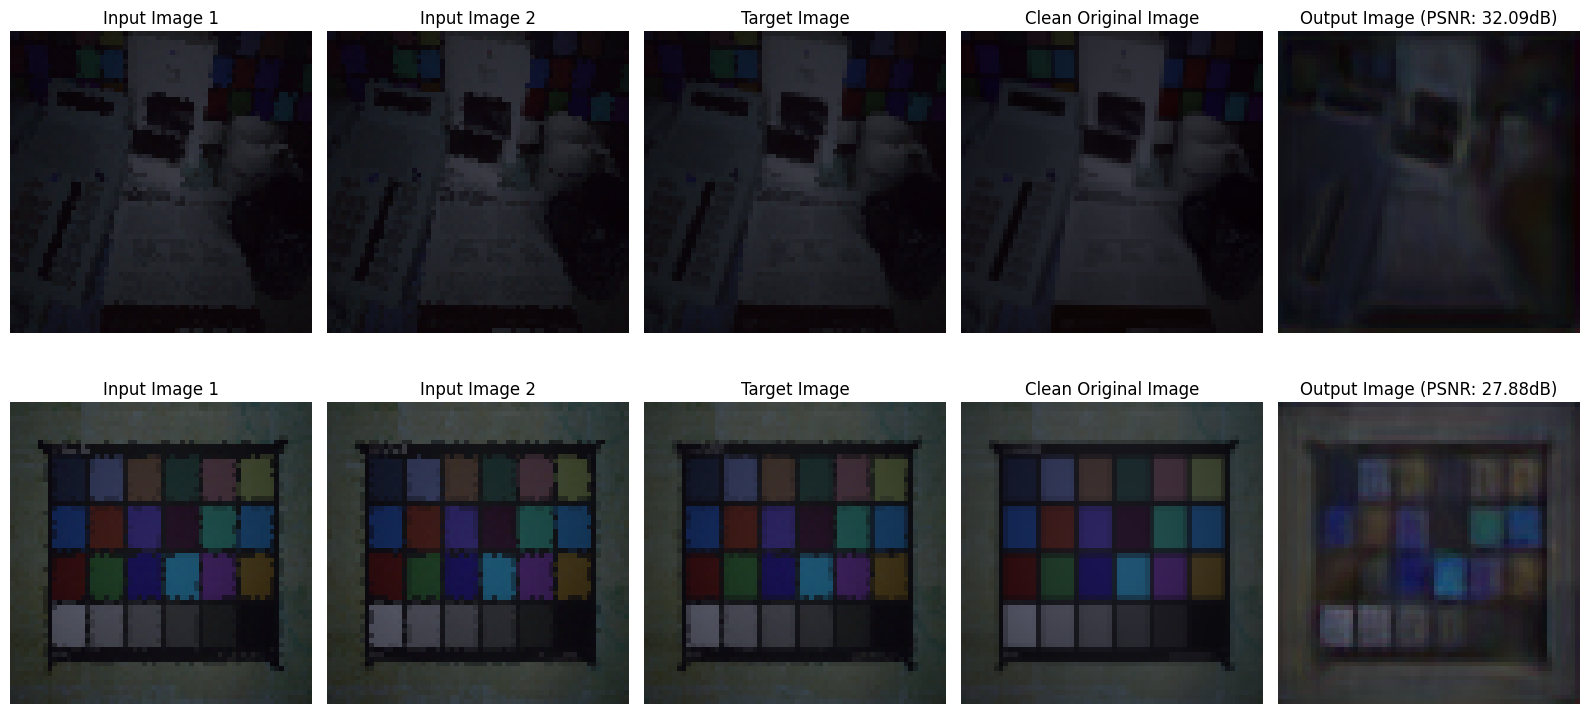

Epoch 66/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 66/100 - Train Loss: 0.0029, Val Loss: 0.0021, Val PSNR: 28.08dB


Epoch 67/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.38it/s]


Epoch 67/100 - Train Loss: 0.0026, Val Loss: 0.0020, Val PSNR: 28.55dB
모델 저장됨 (Val Loss: 0.0020)


Epoch 68/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 75.83it/s]


Epoch 68/100 - Train Loss: 0.0026, Val Loss: 0.0019, Val PSNR: 28.90dB
모델 저장됨 (Val Loss: 0.0019)


Epoch 69/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 69/100 - Train Loss: 0.0026, Val Loss: 0.0023, Val PSNR: 27.60dB


Epoch 70/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.10it/s]


Epoch 70/100 - Train Loss: 0.0024, Val Loss: 0.0024, Val PSNR: 27.62dB


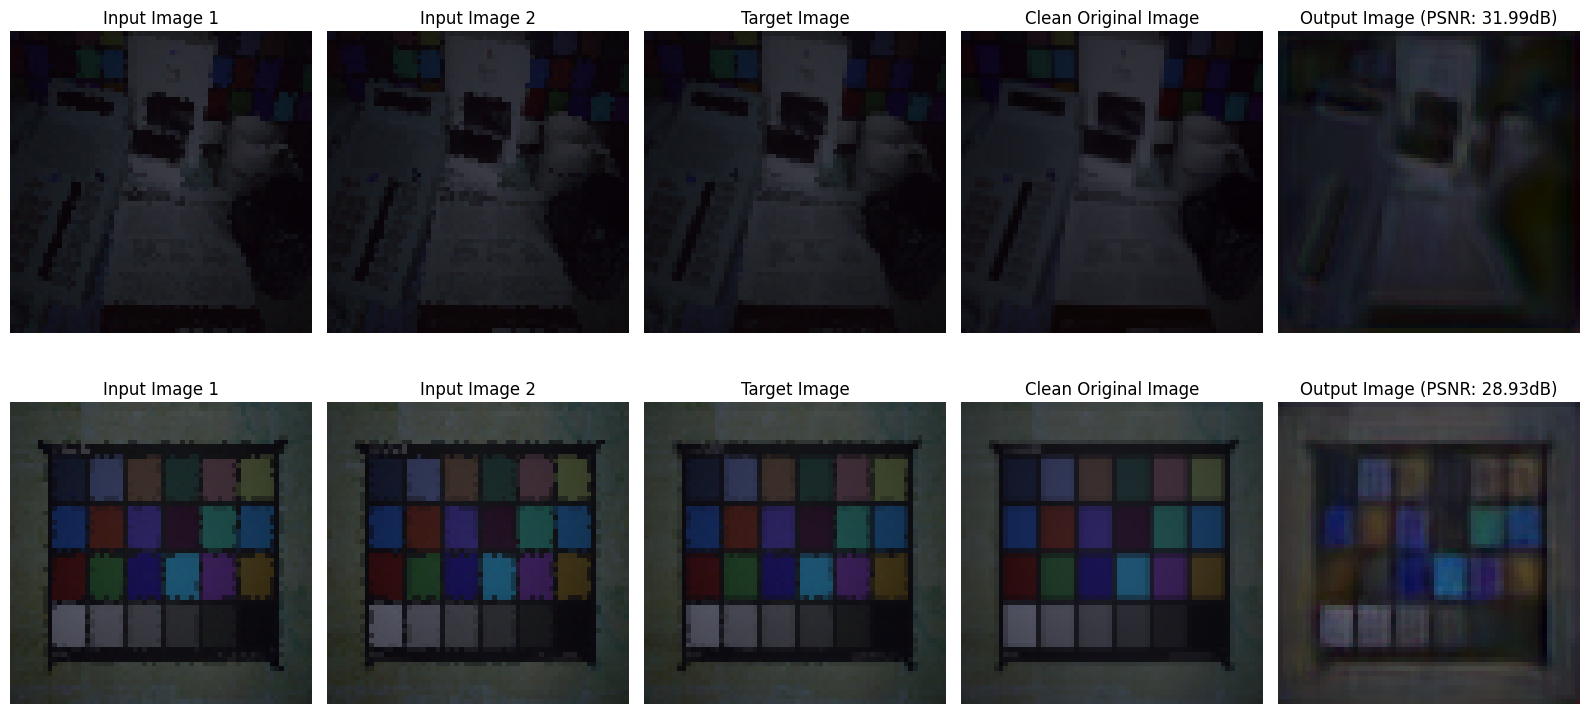

Epoch 71/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.47it/s]


Epoch 71/100 - Train Loss: 0.0033, Val Loss: 0.0044, Val PSNR: 24.92dB


Epoch 72/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.41it/s]


Epoch 72/100 - Train Loss: 0.0036, Val Loss: 0.0037, Val PSNR: 25.46dB


Epoch 73/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 73/100 - Train Loss: 0.0035, Val Loss: 0.0034, Val PSNR: 27.22dB


Epoch 74/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 74/100 - Train Loss: 0.0027, Val Loss: 0.0030, Val PSNR: 27.09dB


Epoch 75/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 84.33it/s]


Epoch 75/100 - Train Loss: 0.0029, Val Loss: 0.0043, Val PSNR: 25.10dB


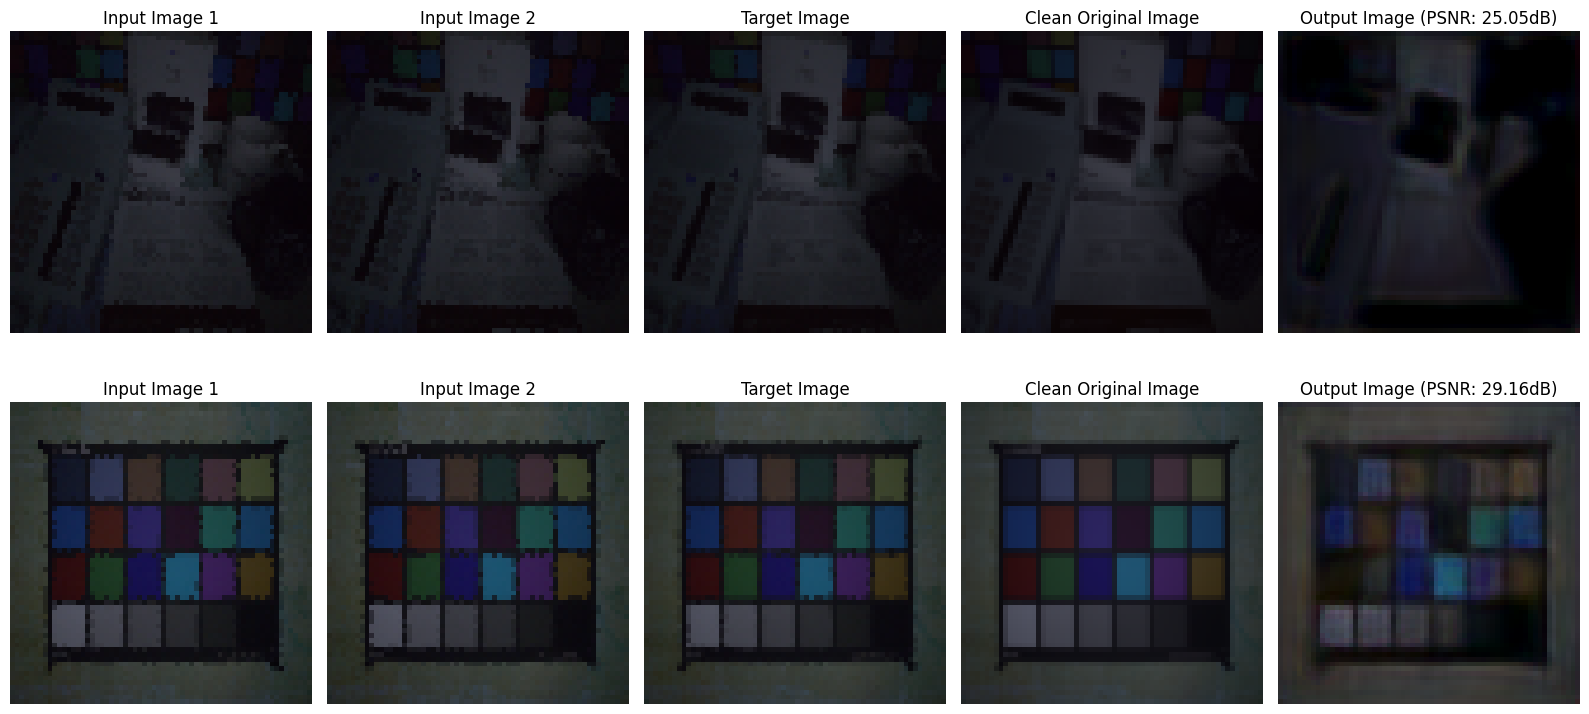

Epoch 76/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.56it/s]


Epoch 76/100 - Train Loss: 0.0026, Val Loss: 0.0033, Val PSNR: 26.72dB


Epoch 77/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.44it/s]


Epoch 77/100 - Train Loss: 0.0024, Val Loss: 0.0025, Val PSNR: 27.68dB


Epoch 78/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 78/100 - Train Loss: 0.0024, Val Loss: 0.0024, Val PSNR: 27.88dB


Epoch 79/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 84.65it/s]


Epoch 79/100 - Train Loss: 0.0023, Val Loss: 0.0018, Val PSNR: 29.03dB
모델 저장됨 (Val Loss: 0.0018)


Epoch 80/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 80/100 - Train Loss: 0.0024, Val Loss: 0.0023, Val PSNR: 28.36dB


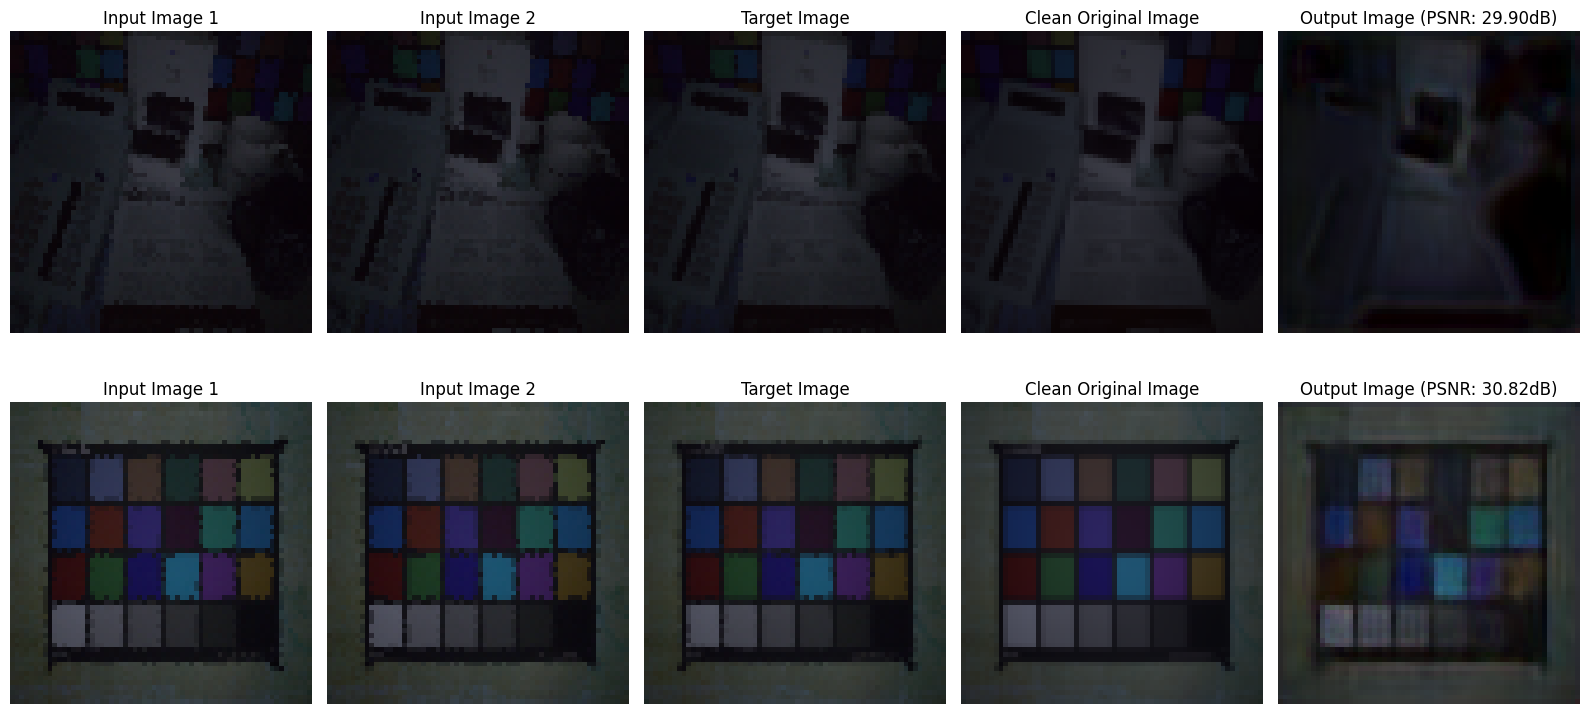

Epoch 81/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.38it/s]


Epoch 81/100 - Train Loss: 0.0033, Val Loss: 0.0020, Val PSNR: 28.56dB


Epoch 82/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.48it/s]


Epoch 82/100 - Train Loss: 0.0027, Val Loss: 0.0022, Val PSNR: 28.45dB


Epoch 83/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.58it/s]


Epoch 83/100 - Train Loss: 0.0022, Val Loss: 0.0019, Val PSNR: 29.01dB


Epoch 84/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 87.43it/s]


Epoch 84/100 - Train Loss: 0.0026, Val Loss: 0.0019, Val PSNR: 28.98dB


Epoch 85/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.95it/s]


Epoch 85/100 - Train Loss: 0.0027, Val Loss: 0.0021, Val PSNR: 28.42dB


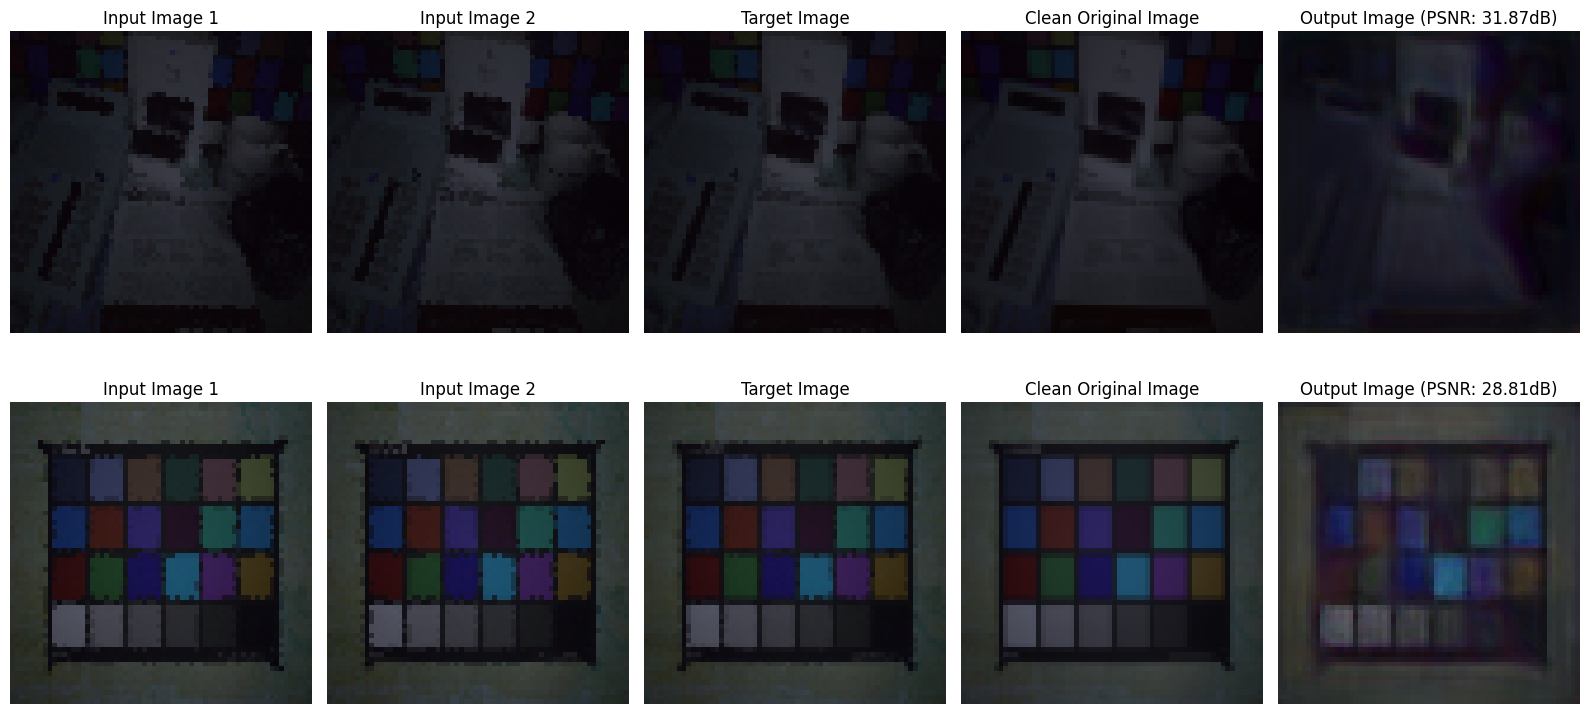

Epoch 86/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 86/100 - Train Loss: 0.0026, Val Loss: 0.0020, Val PSNR: 28.79dB


Epoch 87/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


Epoch 87/100 - Train Loss: 0.0027, Val Loss: 0.0018, Val PSNR: 29.00dB


Epoch 88/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 88/100 - Train Loss: 0.0031, Val Loss: 0.0022, Val PSNR: 28.10dB


Epoch 89/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.15it/s]


Epoch 89/100 - Train Loss: 0.0023, Val Loss: 0.0019, Val PSNR: 28.58dB


Epoch 90/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 88.39it/s]


Epoch 90/100 - Train Loss: 0.0025, Val Loss: 0.0020, Val PSNR: 28.47dB


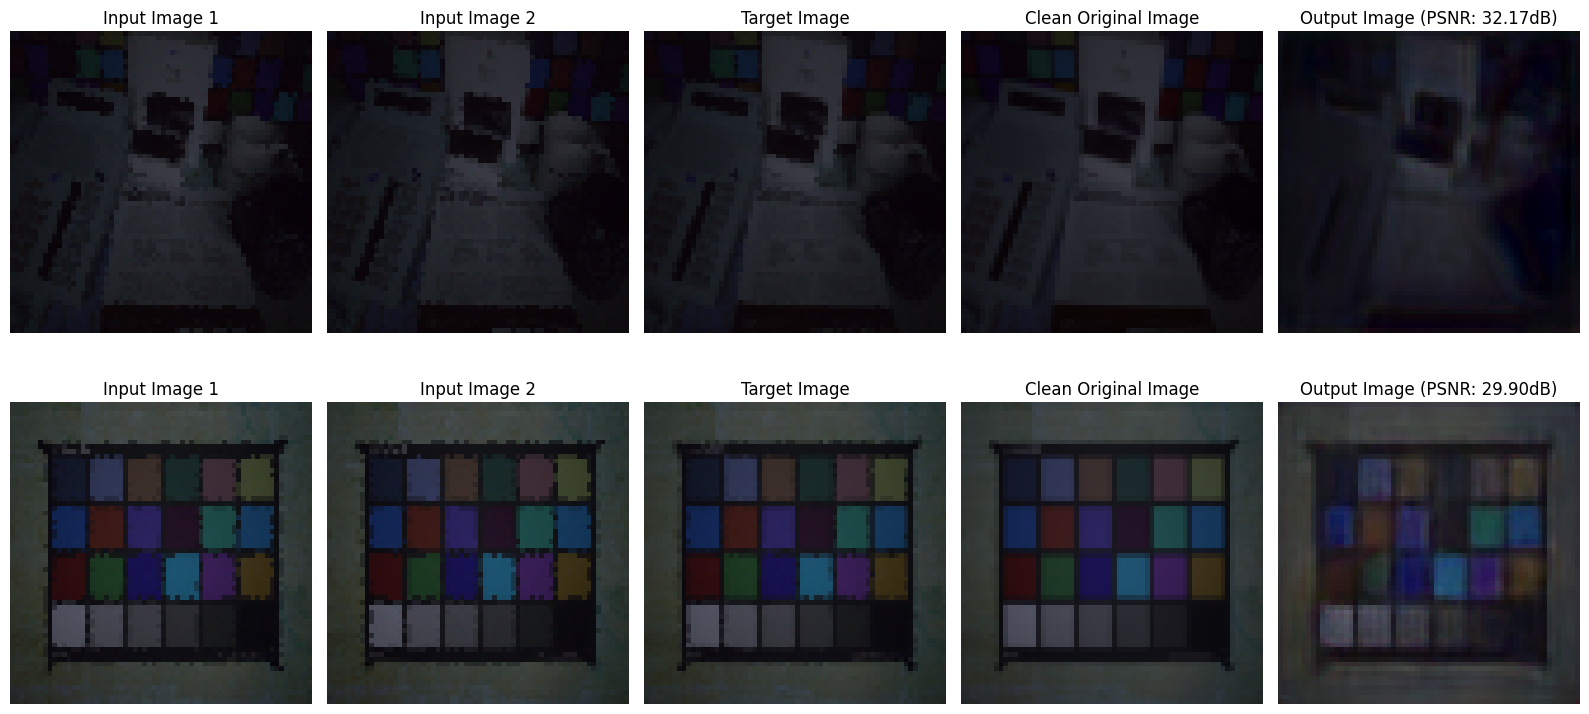

Epoch 91/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 89.38it/s]


Epoch 91/100 - Train Loss: 0.0025, Val Loss: 0.0023, Val PSNR: 27.98dB


Epoch 92/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.41it/s]


Epoch 92/100 - Train Loss: 0.0023, Val Loss: 0.0019, Val PSNR: 28.85dB


Epoch 93/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.93it/s]


Epoch 93/100 - Train Loss: 0.0022, Val Loss: 0.0019, Val PSNR: 29.06dB


Epoch 94/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.43it/s]


Epoch 94/100 - Train Loss: 0.0025, Val Loss: 0.0026, Val PSNR: 27.44dB


Epoch 95/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 85.23it/s]


Epoch 95/100 - Train Loss: 0.0022, Val Loss: 0.0025, Val PSNR: 27.97dB


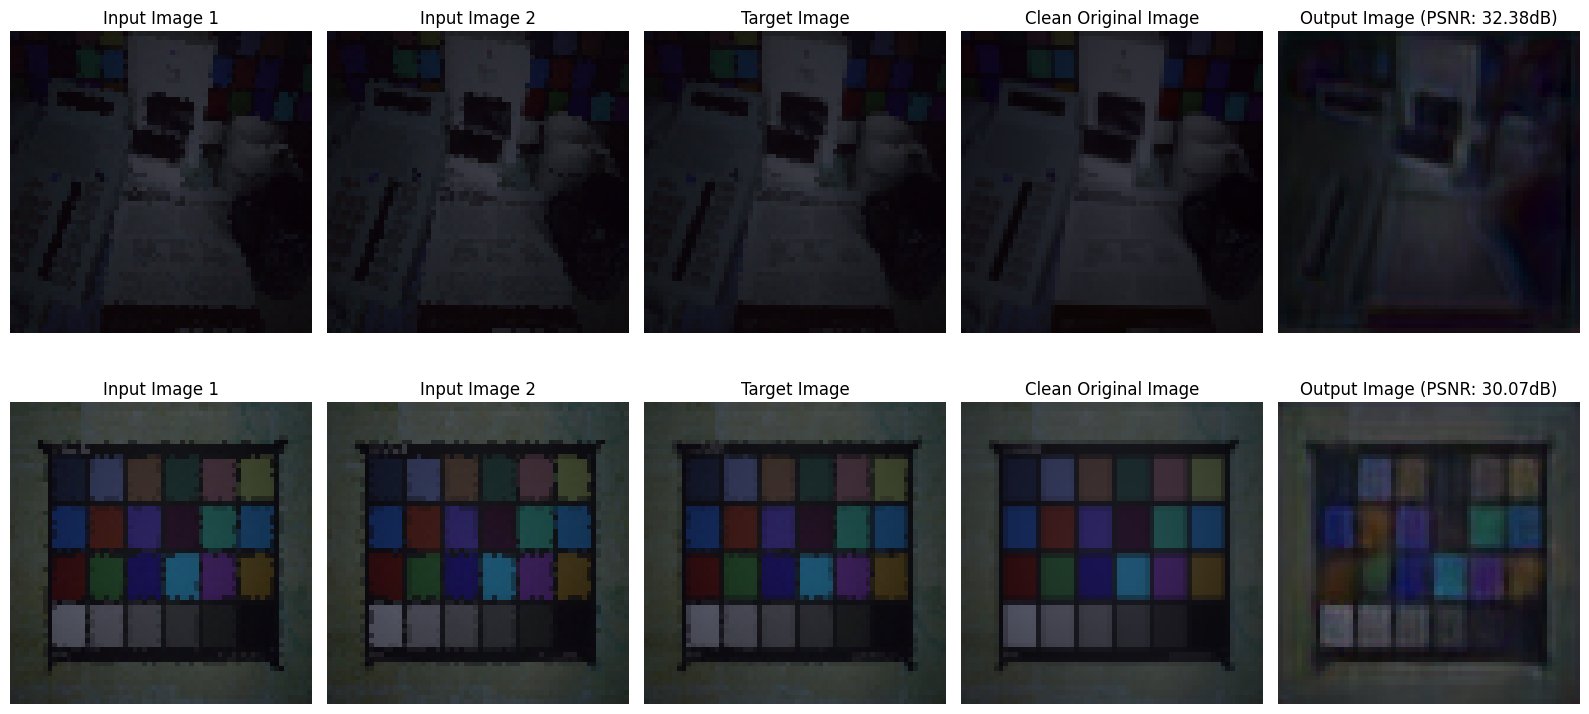

Epoch 96/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.71it/s]


Epoch 96/100 - Train Loss: 0.0022, Val Loss: 0.0025, Val PSNR: 27.14dB


Epoch 97/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.47it/s]


Epoch 97/100 - Train Loss: 0.0024, Val Loss: 0.0027, Val PSNR: 28.03dB


Epoch 98/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 91.42it/s]


Epoch 98/100 - Train Loss: 0.0024, Val Loss: 0.0021, Val PSNR: 29.06dB


Epoch 99/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 93.14it/s]


Epoch 99/100 - Train Loss: 0.0031, Val Loss: 0.0021, Val PSNR: 28.79dB


Epoch 100/100 [Val]: 100%|██████████| 8/8 [00:00<00:00, 92.48it/s]


Epoch 100/100 - Train Loss: 0.0021, Val Loss: 0.0029, Val PSNR: 27.02dB


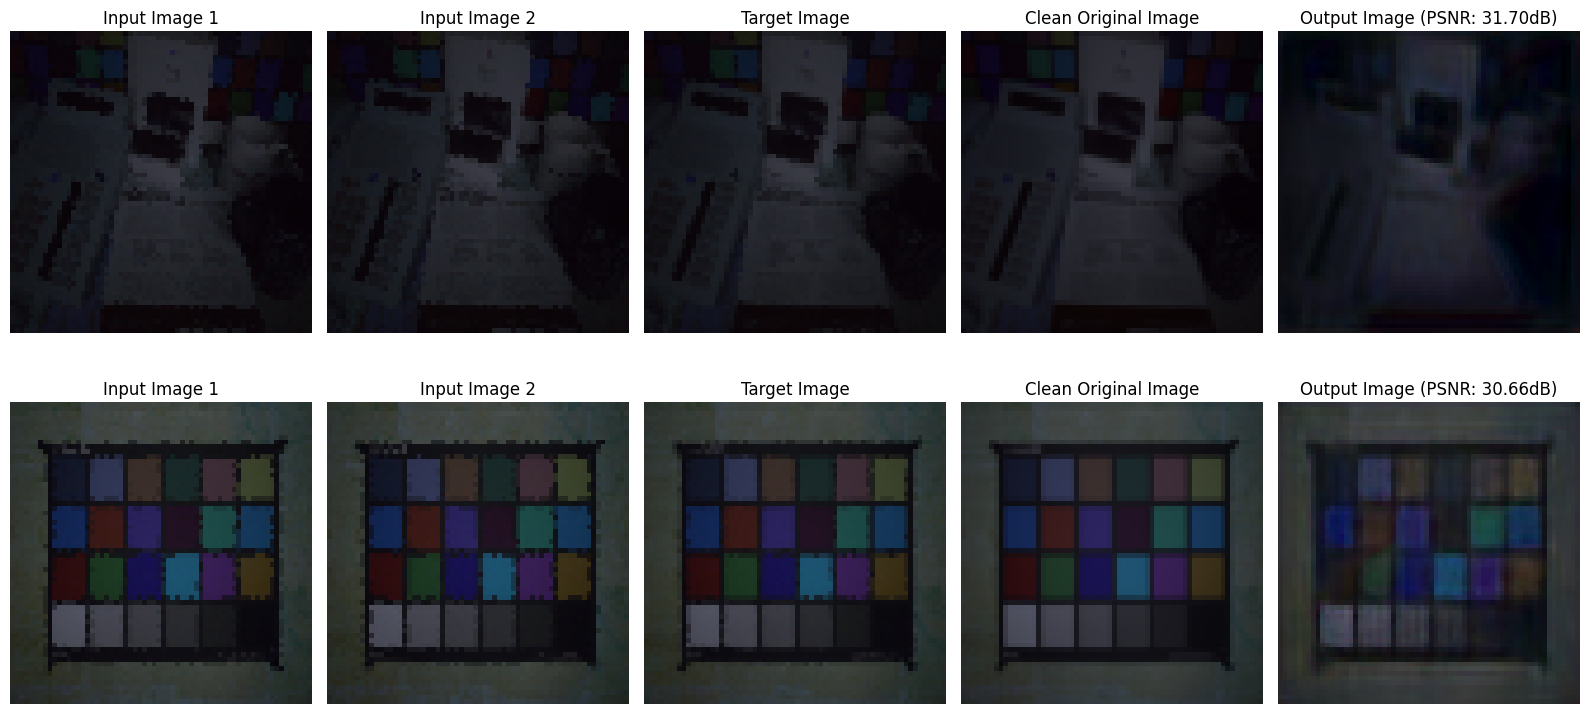

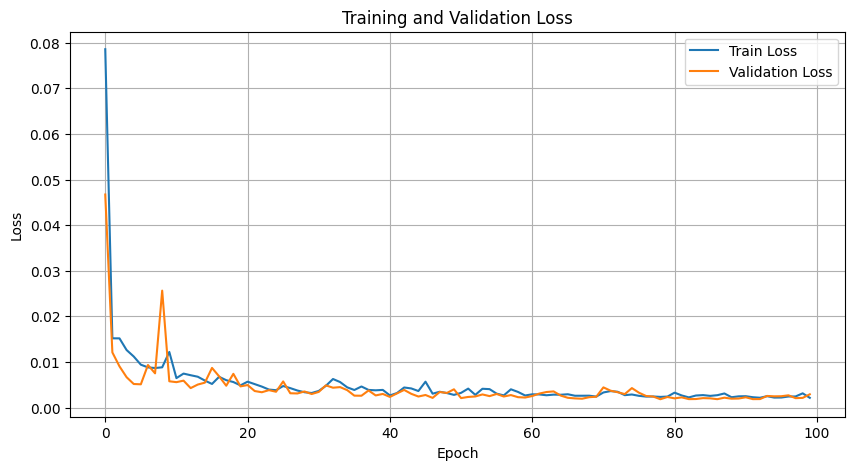

최종 모델 저장 완료: ./checkpoints\final_dncnn_model_ca.pth
최종 결과 시각화 중...


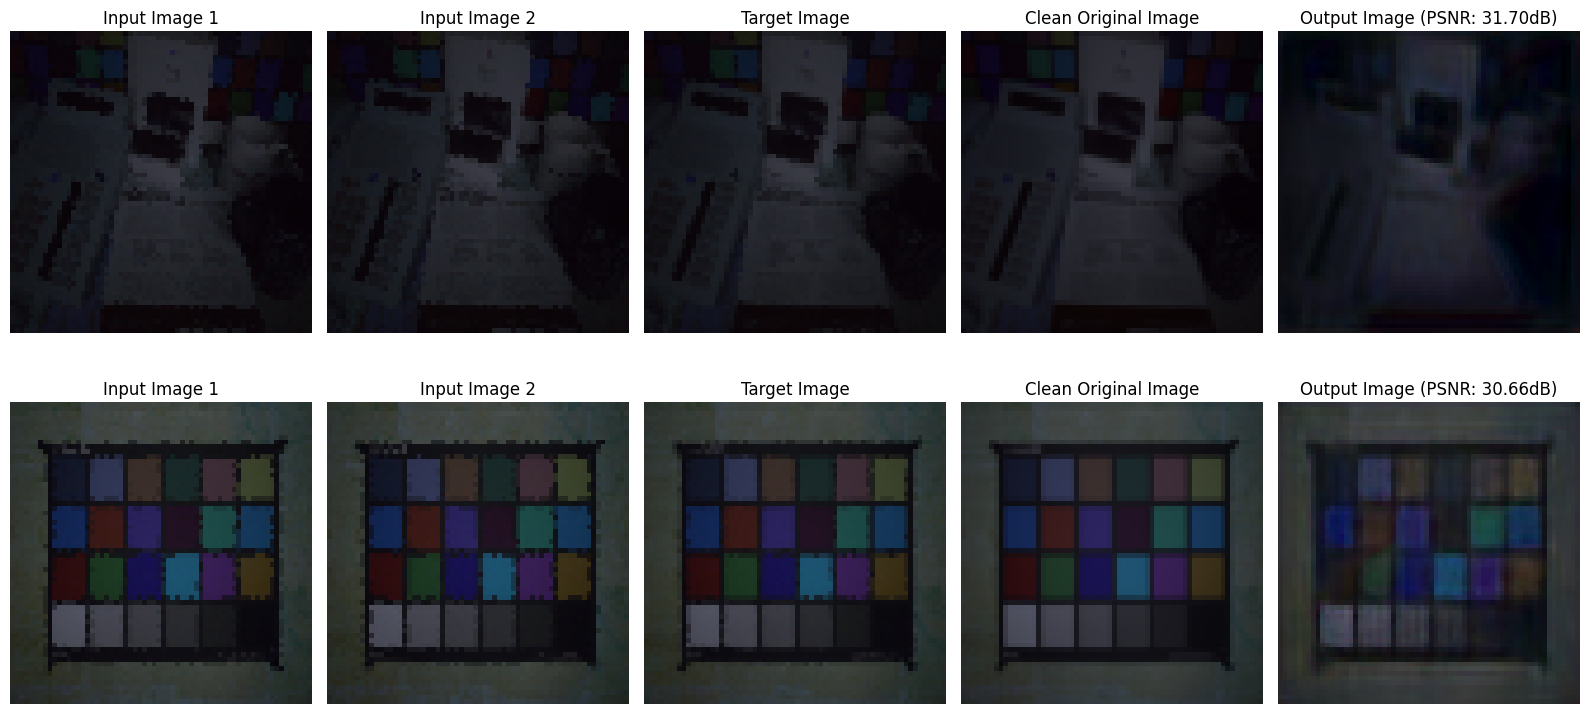

학습 및 평가 완료!


In [10]:
# 실행 코드
if __name__ == "__main__":
    # 하이퍼파라미터 설정
    num_epochs = 100  # 학습 에폭 수
    batch_size = 4   # 배치 크기
    learning_rate = 0.0001  # 학습률
    img_size = 128  # 이미지 크기
    ca = 'ca'  # 'ca'로 설정하면 채널 어텐션 모델 사용
    
    # 학습 실행
    model, train_losses, val_losses = main(
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        img_size=img_size,
        ca=ca
    )